Created directory structure in: .
Could not import from src directory: No module named 'enhanced_data_preparation'
Using built-in functions instead

1. Loading and preprocessing data...
No data files found. Creating sample data...
Creating sample data for demonstration...
Created sample claims data: 1000 rows, 6 columns
Created sample members data: 200 rows, 8 columns


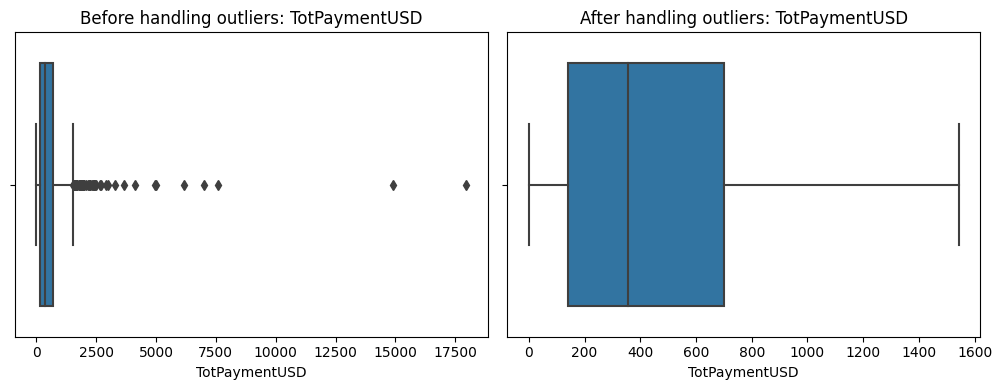

Detected and handled 60 outliers in claims amount
Saved preprocessed data to ./data/processed/

Sample of Claims Data:


,Claim_ID,Member_ID,ServiceDate,ServiceType,TotPaymentUSD,Country
0,C00001,M00103,2020-01-01,Medical,1541.944514,UK
1,C00002,M00180,2020-01-02,Medical,600.307122,USA
2,C00003,M00093,2020-01-03,Emergency,104.880215,Japan
3,C00004,M00015,2020-01-04,Vision,1067.000114,France
4,C00005,M00107,2020-01-05,Dental,1541.944514,Germany



Sample of Members Data:


,Member_ID,Age,Gender,PolicyStartDate,PolicyEndDate,PolicyType,DateOfBirth,RiskScore
0,M00001,23,F,2019-01-01,2021-01-01,Basic,1940-01-01 00:00:00.000000000,24.500604
1,M00002,69,F,2019-01-02,2021-01-02,Premium,1940-04-20 03:00:54.271356784,46.109124
2,M00003,20,M,2019-01-03,2021-01-03,Basic,1940-08-08 06:01:48.542713568,64.030881
3,M00004,80,M,2019-01-04,2021-01-04,Premium,1940-11-26 09:02:42.814070352,46.938601
4,M00005,66,F,2019-01-05,2021-01-05,Basic,1941-03-16 12:03:37.085427136,56.683083



Claims Data Summary:


,TotPaymentUSD
count,1000.000000
mean,483.589610
std,431.280862
min,0.166281
25%,140.049967
50%,355.810490
75%,700.807785
max,1541.944514



Members Data Summary:


,Age,RiskScore
count,200.000000,200.000000
mean,52.260000,52.038216
std,19.486947,14.628876
min,18.000000,10.598206
25%,36.000000,43.949013
50%,52.000000,52.724136
75%,69.000000,60.843361
max,84.000000,88.437915


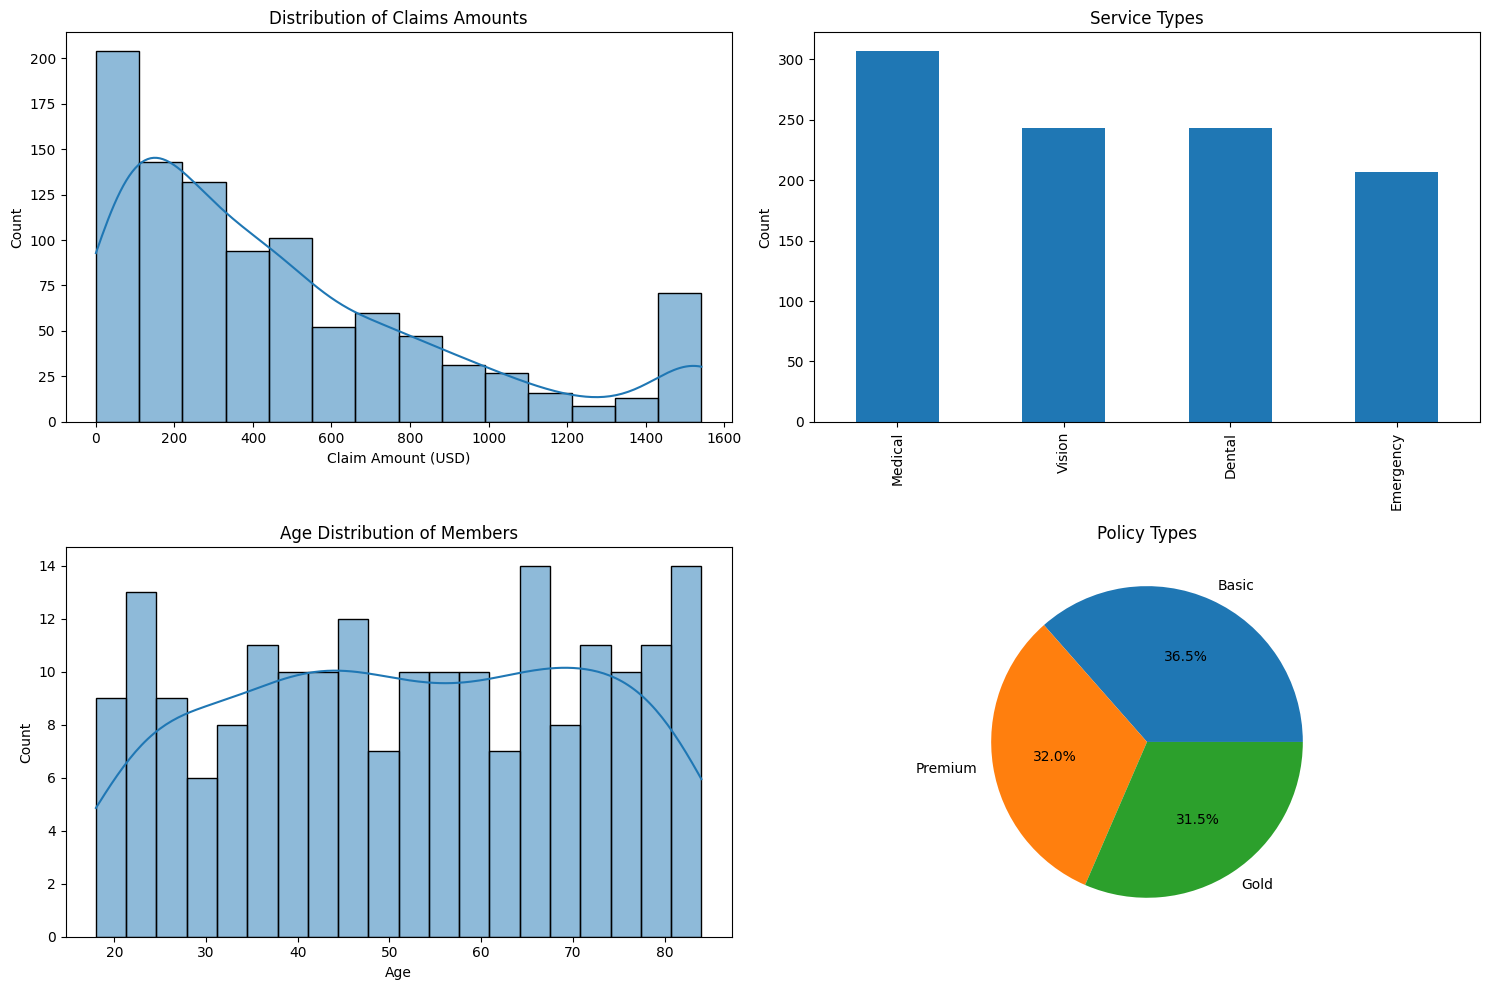


Saved path information to ./paths_info.json for use in other notebooks

Data loading and preprocessing complete!
Proceed to the next notebook: 02_basic_feature_engineering.ipynb


In [2]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import sys
warnings.filterwarnings('ignore')

# Create local directories to store our data
base_dir = '.'  # Current directory
for folder in ['data/raw', 'data/processed', 'models', 'outputs/figures/predictions', 'outputs/tables', 'reports']:
    os.makedirs(f"{base_dir}/{folder}", exist_ok=True)

print(f"Created directory structure in: {base_dir}")

# Try to import functions from the src directory
try:
    from enhanced_data_preparation import handle_missing_values_advanced, detect_and_handle_outliers, scale_features
    print("Successfully imported functions from src directory")
except ImportError as e:
    print(f"Could not import from src directory: {e}")
    print("Using built-in functions instead")

    def handle_missing_values_advanced(df):
        """
        Advanced handling of missing values in a DataFrame.
        """
        # Get columns with missing values
        cols_with_missing = df.columns[df.isnull().any()].tolist()

        for col in cols_with_missing:
            # Check the data type of the column
            if pd.api.types.is_numeric_dtype(df[col]):
                # Handle numeric columns with median
                df[col].fillna(df[col].median(), inplace=True)
            elif pd.api.types.is_datetime64_dtype(df[col]):
                # Handle date columns with forward fill then backward fill
                df[col].fillna(method='ffill', inplace=True)
                df[col].fillna(method='bfill', inplace=True)
            else:
                # Handle categorical/object columns with mode
                df[col].fillna(df[col].mode()[0], inplace=True)

        return df

    def detect_and_handle_outliers(df, columns, method='iqr', visualization=False):
        """
        Detect and handle outliers in specified columns.
        """
        outliers_info = {}
        df_processed = df.copy()

        for col in columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                if method == 'iqr':
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR

                    # Identify outliers
                    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
                    outliers_info[col] = outliers.tolist()

                    # Cap outliers
                    df_processed.loc[df_processed[col] < lower_bound, col] = lower_bound
                    df_processed.loc[df_processed[col] > upper_bound, col] = upper_bound

                    if visualization:
                        plt.figure(figsize=(10, 4))
                        plt.subplot(1, 2, 1)
                        sns.boxplot(x=df[col])
                        plt.title(f'Before handling outliers: {col}')

                        plt.subplot(1, 2, 2)
                        sns.boxplot(x=df_processed[col])
                        plt.title(f'After handling outliers: {col}')
                        plt.tight_layout()
                        plt.show()

        return df_processed, outliers_info

    def scale_features(df, method='standard'):
        """
        Scale numeric features in the DataFrame.
        """
        # Only scale the numeric columns
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Create a copy to avoid modifying the original
        df_scaled = df.copy()

        if method == 'standard':
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif method == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif method == 'robust':
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        return df_scaled, scaler

def create_sample_data():
    """Create sample data for demonstration purposes"""
    print("Creating sample data for demonstration...")

    # Create sample claims data
    np.random.seed(42)
    n_claims = 1000
    n_members = 200

    # Generate member IDs
    member_ids = [f'M{i:05d}' for i in range(1, n_members + 1)]

    # Create claims DataFrame
    claims_df = pd.DataFrame({
        'Claim_ID': [f'C{i:05d}' for i in range(1, n_claims + 1)],
        'Member_ID': np.random.choice(member_ids, n_claims),
        'ServiceDate': pd.date_range(start='2020-01-01', periods=n_claims),
        'ServiceType': np.random.choice(['Medical', 'Dental', 'Vision', 'Emergency'], n_claims),
        'TotPaymentUSD': np.random.exponential(500, n_claims),
        'Country': np.random.choice(['USA', 'UK', 'France', 'Germany', 'Japan'], n_claims)
    })

    # Add some outliers to claims
    claims_df.loc[np.random.choice(n_claims, 20), 'TotPaymentUSD'] = np.random.exponential(5000, 20)

    # Create members DataFrame
    members_df = pd.DataFrame({
        'Member_ID': member_ids,
        'Age': np.random.randint(18, 85, n_members),
        'Gender': np.random.choice(['M', 'F'], n_members),
        'PolicyStartDate': pd.date_range(start='2019-01-01', periods=n_members),
        'PolicyEndDate': pd.date_range(start='2021-01-01', periods=n_members),
        'PolicyType': np.random.choice(['Basic', 'Premium', 'Gold'], n_members),
        'DateOfBirth': pd.date_range(start='1940-01-01', end='2000-01-01', periods=n_members),
        'RiskScore': np.random.normal(50, 15, n_members)
    })

    # Add some missing values
    claims_df.loc[np.random.choice(n_claims, 50), 'ServiceType'] = None
    members_df.loc[np.random.choice(n_members, 30), 'RiskScore'] = None

    print(f"Created sample claims data: {claims_df.shape[0]} rows, {claims_df.shape[1]} columns")
    print(f"Created sample members data: {members_df.shape[0]} rows, {members_df.shape[1]} columns")

    return claims_df, members_df

def load_and_preprocess_data():
    """
    Load and preprocess claims and member data
    """
    print("\n1. Loading and preprocessing data...")

    claims_df = None
    members_df = None

    # Check for data files in local data directory
    local_claims_path = f"{base_dir}/data/raw/claims_data.csv"
    local_members_path = f"{base_dir}/data/raw/members_data.csv"

    # Try loading from local directory
    if os.path.exists(local_claims_path) and os.path.exists(local_members_path):
        try:
            print(f"Loading data from local directory: {local_claims_path} and {local_members_path}")
            claims_df = pd.read_csv(local_claims_path)
            members_df = pd.read_csv(local_members_path)
            print(f"Loaded data from local directory: {len(claims_df)} claims, {len(members_df)} members")
        except Exception as e:
            print(f"Error loading data from local directory: {e}")
            claims_df, members_df = None, None

    # If still no data, create sample data
    if claims_df is None or members_df is None:
        print("No data files found. Creating sample data...")
        claims_df, members_df = create_sample_data()

    try:
        # Convert date columns to datetime
        if 'ServiceDate' in claims_df.columns:
            claims_df['ServiceDate'] = pd.to_datetime(claims_df['ServiceDate'])

        date_columns = ['PolicyStartDate', 'PolicyEndDate', 'DateOfBirth']
        for col in date_columns:
            if col in members_df.columns:
                members_df[col] = pd.to_datetime(members_df[col])

        # Handle missing values
        claims_df = handle_missing_values_advanced(claims_df)
        members_df = handle_missing_values_advanced(members_df)

        # Detect and handle outliers in claims amount
        if 'TotPaymentUSD' in claims_df.columns:
            claims_df, outliers_info = detect_and_handle_outliers(
                claims_df,
                columns=['TotPaymentUSD'],
                method='iqr',
                visualization=True
            )
            print(f"Detected and handled {len(outliers_info.get('TotPaymentUSD', []))} outliers in claims amount")

        # Save processed data to local filesystem
        claims_df.to_csv(f'{base_dir}/data/processed/claims_data_clean.csv', index=False)
        members_df.to_csv(f'{base_dir}/data/processed/members_data_clean.csv', index=False)

        print(f"Saved preprocessed data to {base_dir}/data/processed/")

        return claims_df, members_df

    except Exception as e:
        print(f"Error preprocessing data: {e}")
        return None, None

# Execute the data loading and preprocessing
claims_df, members_df = load_and_preprocess_data()

# Check if data was properly created/loaded
if claims_df is not None and members_df is not None:
    # Display sample of the data
    print("\nSample of Claims Data:")
    display(claims_df.head())

    print("\nSample of Members Data:")
    display(members_df.head())

    # Basic data exploration
    print("\nClaims Data Summary:")
    display(claims_df.describe())

    print("\nMembers Data Summary:")
    display(members_df.describe())

    # Visualize distributions
    plt.figure(figsize=(15, 10))

    # Claims amount distribution
    plt.subplot(2, 2, 1)
    if 'TotPaymentUSD' in claims_df.columns:
        sns.histplot(claims_df['TotPaymentUSD'], kde=True)
        plt.title('Distribution of Claims Amounts')
        plt.xlabel('Claim Amount (USD)')
    else:
        plt.text(0.5, 0.5, 'TotPaymentUSD column not found', ha='center', va='center')

    # Service types
    plt.subplot(2, 2, 2)
    if 'ServiceType' in claims_df.columns:
        claims_df['ServiceType'].value_counts().plot(kind='bar')
        plt.title('Service Types')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'ServiceType column not found', ha='center', va='center')

    # Age distribution
    plt.subplot(2, 2, 3)
    if 'Age' in members_df.columns:
        sns.histplot(members_df['Age'], bins=20, kde=True)
        plt.title('Age Distribution of Members')
        plt.xlabel('Age')
    else:
        plt.text(0.5, 0.5, 'Age column not found', ha='center', va='center')

    # Policy types
    plt.subplot(2, 2, 4)
    if 'PolicyType' in members_df.columns:
        members_df['PolicyType'].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Policy Types')
        plt.ylabel('')
    else:
        plt.text(0.5, 0.5, 'PolicyType column not found', ha='center', va='center')

    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/data_exploration.png')
    plt.show()

    # Save path information for other notebooks
    paths_info = {
        "base_dir": base_dir
    }
    import json
    with open(f'{base_dir}/paths_info.json', 'w') as f:
        json.dump(paths_info, f)
    print(f"\nSaved path information to {base_dir}/paths_info.json for use in other notebooks")

    print("\nData loading and preprocessing complete!")
    print(f"Proceed to the next notebook: 02_basic_feature_engineering.ipynb")
else:
    print("\nError: Data loading and preprocessing failed. Please check the error messages above.")

Using existing data from Block 1: 1000 claims, 200 members

2. Engineering basic features...
Using cutoff date: 2022-03-30 00:00:00
Column names after aggregation: ['Member_ID', 'ServiceDate_min', 'ServiceDate_max', 'TotPaymentUSD_sum', 'TotPaymentUSD_mean', 'TotPaymentUSD_std', 'TotPaymentUSD_min', 'TotPaymentUSD_max']
Final customer feature columns: ['Member_ID', 'first_claim_date', 'last_claim_date', 'total_claim_amount', 'avg_claim_amount', 'std_claim_amount', 'min_claim_amount', 'max_claim_amount', 'claim_count', 'days_since_first_claim', 'days_since_last_claim', 'active_months', 'claim_frequency']
Created 13 customer behavior features
Created target variable with 117 members having future claims
Successfully engineered basic features: 21 total features
Features saved to: ./data/processed/basic_features.csv


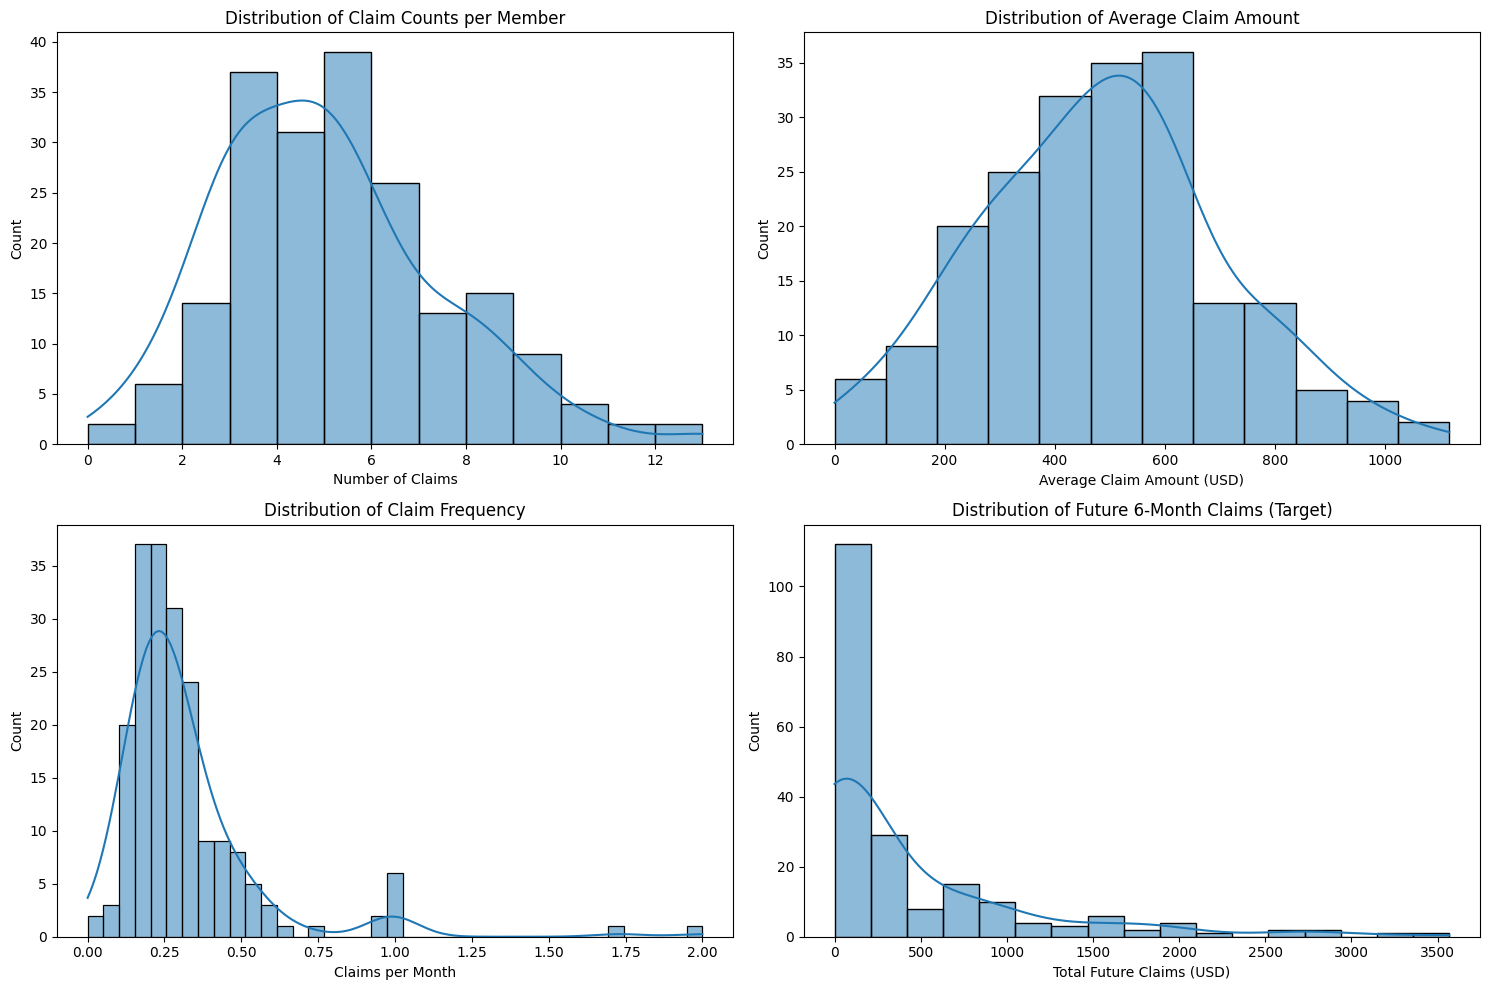

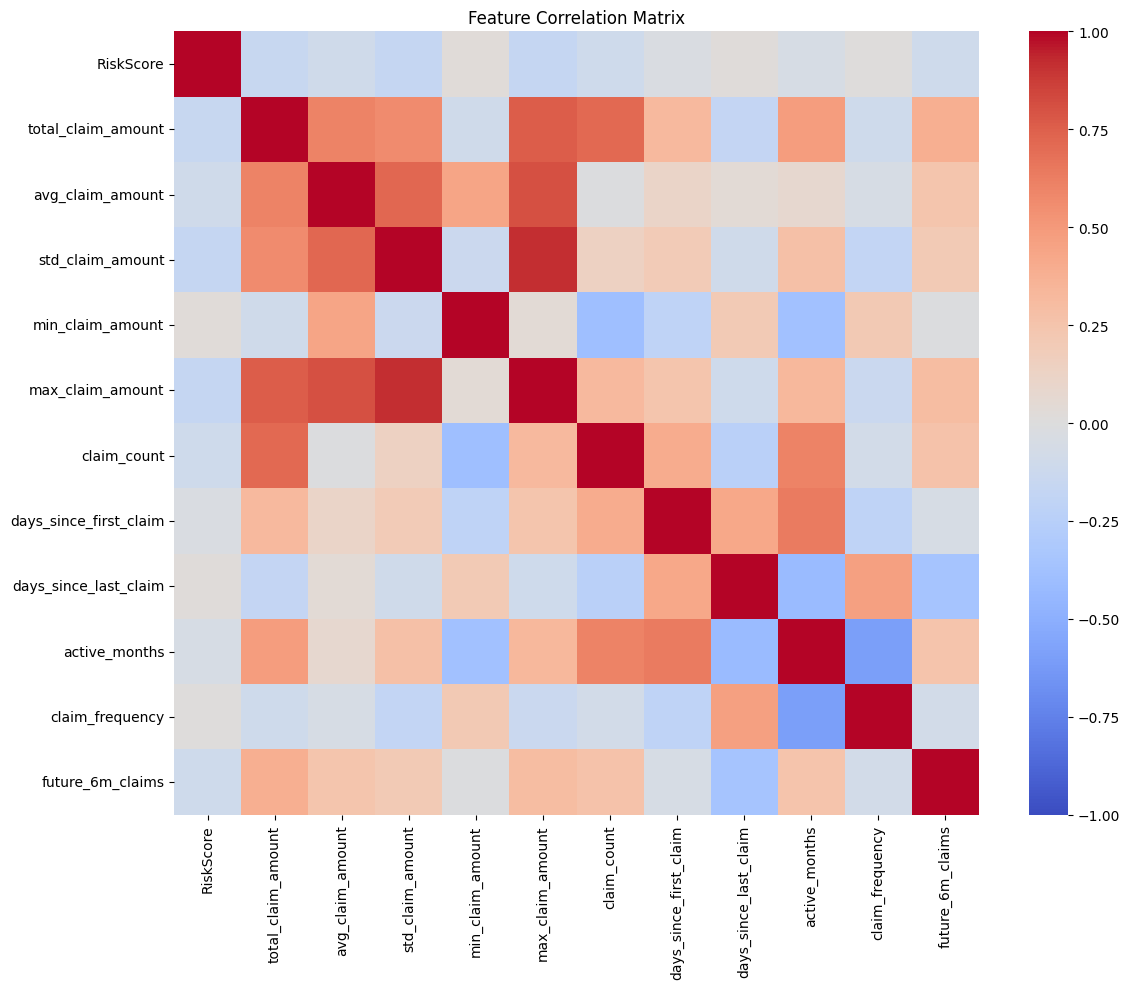


Basic feature engineering complete!


In [3]:
# @title ## 2. Basic Feature Engineering
# @markdown In this block, we create basic date features and customer behavior features.

# No need to re-import libraries or mount Google Drive since this is part of a single notebook
# We can directly use the base_dir and other variables from block 1

def create_date_features(df, date_column):
    """
    Create features from date columns
    """
    df_copy = df.copy()

    # Extract components
    df_copy[f'{date_column}_year'] = df_copy[date_column].dt.year
    df_copy[f'{date_column}_month'] = df_copy[date_column].dt.month
    df_copy[f'{date_column}_dayofmonth'] = df_copy[date_column].dt.day
    df_copy[f'{date_column}_dayofweek'] = df_copy[date_column].dt.dayofweek
    df_copy[f'{date_column}_quarter'] = df_copy[date_column].dt.quarter

    # Create is_weekend feature
    df_copy[f'{date_column}_is_weekend'] = df_copy[f'{date_column}_dayofweek'].isin([5, 6]).astype(int)

    return df_copy

def create_cyclical_features(df, feature_name, period):
    """
    Create cyclical features for temporal data to handle its circular nature
    """
    df_copy = df.copy()

    # Create sin and cos features
    df_copy[f'{feature_name}_sin'] = np.sin(2 * np.pi * df_copy[feature_name] / period)
    df_copy[f'{feature_name}_cos'] = np.cos(2 * np.pi * df_copy[feature_name] / period)

    return df_copy

def create_customer_behavior_features(df, member_id_col, date_col, amount_col):
    """
    Create customer behavior features from claims history
    """
    try:
        # Group by customer with clearer column naming
        agg_dict = {}
        # For count of claims
        agg_dict[date_col] = ['count']
        # For payment amount stats
        agg_dict[amount_col] = ['sum', 'mean', 'std', 'min', 'max']
        # For first and last claim dates
        agg_dict[date_col] = ['min', 'max']

        # Group by customer
        customer_features = df.groupby(member_id_col).agg(agg_dict)

        # Flatten the column hierarchy and make column names
        customer_features.columns = [f"{x[0]}_{x[1]}" for x in customer_features.columns]

        # Reset index to get member_id as a column
        customer_features = customer_features.reset_index()

        # Print column names for debugging
        print(f"Column names after aggregation: {customer_features.columns.tolist()}")

        # Create claim count explicitly if column naming didn't work as expected
        if f'{date_col}_count' not in customer_features.columns:
            # Count claims per member directly
            claim_counts = df.groupby(member_id_col)[date_col].count().reset_index()
            claim_counts = claim_counts.rename(columns={date_col: 'claim_count'})
            # Merge with customer features
            customer_features = customer_features.merge(claim_counts, on=member_id_col, how='left')
        else:
            # Rename existing column
            customer_features = customer_features.rename(columns={
                f'{date_col}_count': 'claim_count'
            })

        # Rename other columns for clarity
        rename_dict = {
            f'{amount_col}_sum': 'total_claim_amount',
            f'{amount_col}_mean': 'avg_claim_amount',
            f'{amount_col}_std': 'std_claim_amount',
            f'{amount_col}_min': 'min_claim_amount',
            f'{amount_col}_max': 'max_claim_amount',
            f'{date_col}_min': 'first_claim_date',
            f'{date_col}_max': 'last_claim_date'
        }

        # Only rename columns that exist
        rename_dict = {k: v for k, v in rename_dict.items() if k in customer_features.columns}
        customer_features = customer_features.rename(columns=rename_dict)

        # Calculate days since first and last claim
        today = pd.Timestamp.now().normalize()
        if 'first_claim_date' in customer_features.columns:
            customer_features['days_since_first_claim'] = (today - customer_features['first_claim_date']).dt.days

        if 'last_claim_date' in customer_features.columns:
            customer_features['days_since_last_claim'] = (today - customer_features['last_claim_date']).dt.days

        # Calculate claim frequency (claims per month)
        if 'first_claim_date' in customer_features.columns and 'last_claim_date' in customer_features.columns:
            customer_features['active_months'] = (
                (customer_features['last_claim_date'] - customer_features['first_claim_date']).dt.days / 30
            ).apply(lambda x: max(x, 1))  # Avoid division by zero

            if 'claim_count' in customer_features.columns:
                customer_features['claim_frequency'] = customer_features['claim_count'] / customer_features['active_months']

        # Handle infinity or NaN values
        customer_features.replace([np.inf, -np.inf], np.nan, inplace=True)
        customer_features.fillna(0, inplace=True)

        print(f"Final customer feature columns: {customer_features.columns.tolist()}")
        return customer_features

    except Exception as e:
        print(f"Error in creating customer behavior features: {e}")
        # Return a minimal DataFrame with just Member_ID to allow the process to continue
        minimal_df = pd.DataFrame({member_id_col: df[member_id_col].unique()})
        # Add a dummy claim_count column
        minimal_df['claim_count'] = 0
        return minimal_df

def create_target_variable(claims_df, cutoff_date, prediction_window=180):
    """
    Create target variable by calculating total claims per member in the future window
    """
    try:
        end_date = cutoff_date + timedelta(days=prediction_window)

        # Filter claims in prediction window
        future_claims = claims_df[
            (claims_df['ServiceDate'] > cutoff_date) &
            (claims_df['ServiceDate'] <= end_date)
        ]

        # Calculate total claims per member in prediction window
        future_agg = future_claims.groupby('Member_ID')['TotPaymentUSD'].sum().reset_index()
        future_agg.rename(columns={'TotPaymentUSD': 'future_6m_claims'}, inplace=True)

        print(f"Created target variable with {len(future_agg)} members having future claims")
        return future_agg

    except Exception as e:
        print(f"Error creating target variable: {e}")
        return pd.DataFrame({'Member_ID': claims_df['Member_ID'].unique(), 'future_6m_claims': 0})

def engineer_basic_features(claims_df, members_df):
    """
    Engineer basic features from claims and member data
    """
    print("\n2. Engineering basic features...")

    try:
        # Define cutoff date for train/test split and prediction window
        max_date = claims_df['ServiceDate'].max()
        cutoff_date = max_date - timedelta(days=180)  # 6 months

        print(f"Using cutoff date: {cutoff_date}")

        # Create date features from claims
        claims_with_dates = create_date_features(claims_df, 'ServiceDate')

        # Create cyclical features for month and day of week
        claims_with_dates = create_cyclical_features(claims_with_dates, 'ServiceDate_month', 12)
        claims_with_dates = create_cyclical_features(claims_with_dates, 'ServiceDate_dayofweek', 7)

        # Create customer behavior features
        customer_features = create_customer_behavior_features(
            claims_df,
            member_id_col='Member_ID',
            date_col='ServiceDate',
            amount_col='TotPaymentUSD'
        )
        print(f"Created {customer_features.shape[1]} customer behavior features")

        # Create target variable (future claims in the next 6 months)
        future_claims = create_target_variable(claims_df, cutoff_date)

        # Merge all features
        features_df = members_df.merge(customer_features, on='Member_ID', how='left')
        features_df = features_df.merge(future_claims, on='Member_ID', how='left')

        # Fill missing values
        features_df = features_df.fillna(0)

        # Save basic features
        features_df.to_csv(f'{base_dir}/data/processed/basic_features.csv', index=False)

        print(f"Successfully engineered basic features: {features_df.shape[1]} total features")
        print(f"Features saved to: {base_dir}/data/processed/basic_features.csv")

        return features_df, cutoff_date, claims_with_dates

    except Exception as e:
        print(f"Error engineering basic features: {e}")
        return None, None, None

# We can directly use the claims_df and members_df from block 1
# No need to load them again from files

print(f"Using existing data from Block 1: {len(claims_df)} claims, {len(members_df)} members")

# Engineer basic features
features_df, cutoff_date, claims_with_dates = engineer_basic_features(claims_df, members_df)

# Visualize some basic features
if features_df is not None:
    plt.figure(figsize=(15, 10))

    # Distribution of claim counts per member
    plt.subplot(2, 2, 1)
    sns.histplot(features_df['claim_count'], kde=True)
    plt.title('Distribution of Claim Counts per Member')
    plt.xlabel('Number of Claims')

    # Distribution of average claim amount
    plt.subplot(2, 2, 2)
    sns.histplot(features_df['avg_claim_amount'], kde=True)
    plt.title('Distribution of Average Claim Amount')
    plt.xlabel('Average Claim Amount (USD)')

    # Distribution of claim frequency
    plt.subplot(2, 2, 3)
    sns.histplot(features_df['claim_frequency'], kde=True)
    plt.title('Distribution of Claim Frequency')
    plt.xlabel('Claims per Month')

    # Distribution of total future claims (target variable)
    plt.subplot(2, 2, 4)
    sns.histplot(features_df['future_6m_claims'], kde=True)
    plt.title('Distribution of Future 6-Month Claims (Target)')
    plt.xlabel('Total Future Claims (USD)')

    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/basic_features.png')
    plt.show()

    # Correlation analysis
    numeric_features = features_df.select_dtypes(include=['int64', 'float64']).columns
    correlation = features_df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/feature_correlation.png')
    plt.show()

    print("\nBasic feature engineering complete!")
else:
    print("\nError: Basic feature engineering failed. Check the error messages above.")

Using data from previous blocks
Claims data: 1000 rows
Members data: 200 rows
Basic features: 200 rows
Using cutoff date: 2022-03-30 00:00:00

Creating advanced temporal features...
Columns before aggregation: ['Claim_ID', 'Member_ID', 'ServiceDate', 'ServiceType', 'TotPaymentUSD', 'Country', 'year_month']
Columns after first aggregation: ['Member_ID', 'year_month', 'payment_sum', 'payment_count']
Columns after second aggregation: ['Member_ID', 'year_month_min', 'year_month_max', 'year_month_count', 'payment_sum_mean', 'payment_sum_std', 'payment_sum_max', 'payment_sum_sum', 'payment_count_mean', 'payment_count_std', 'payment_count_max', 'payment_count_sum']
Created 23 advanced temporal features

Creating enhanced risk scores...
Created 8 risk score features

Total features after adding advanced features: 50
Features saved to ./data/processed/integrated_features.csv


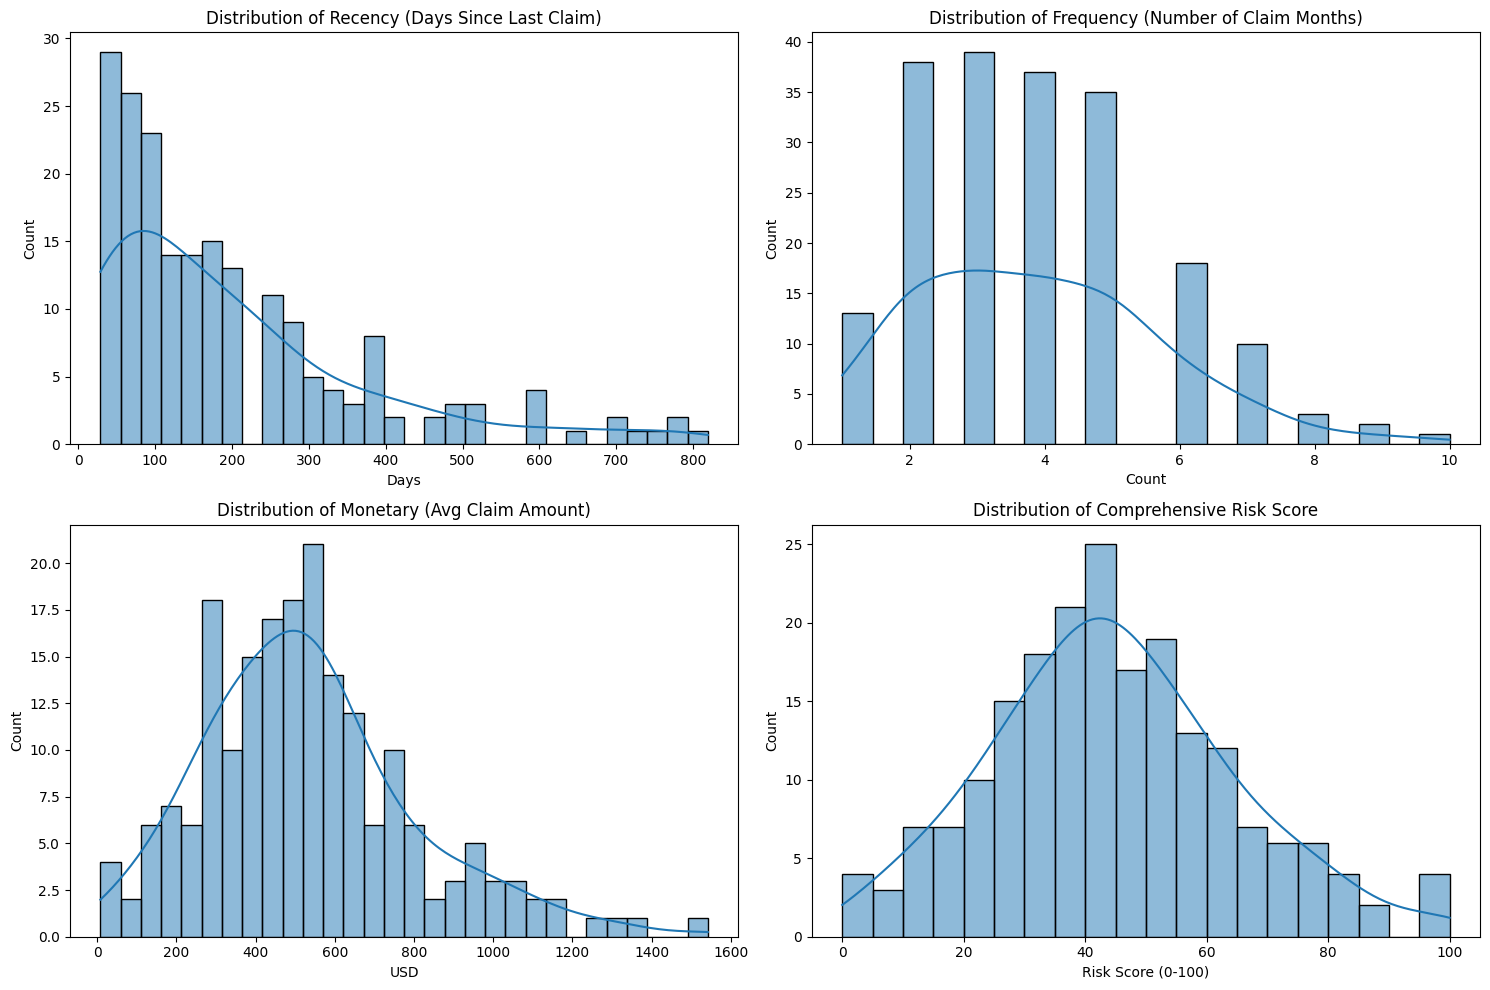

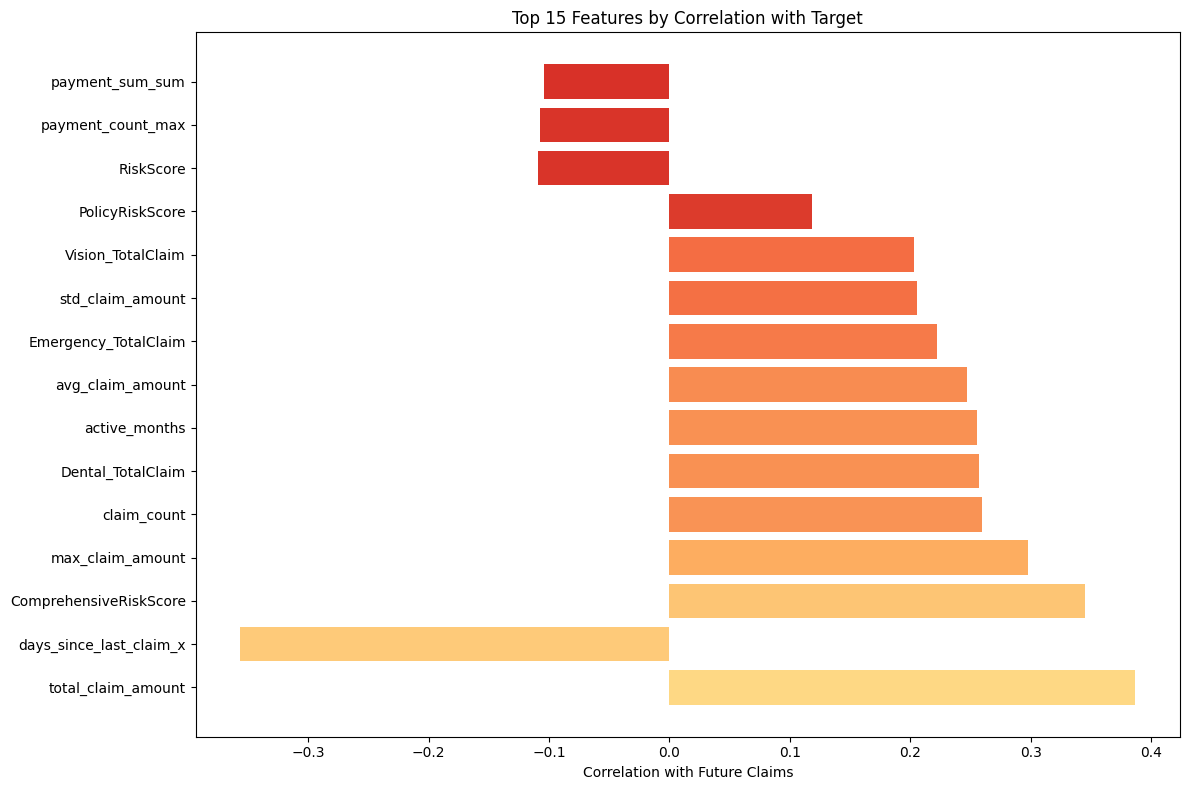


Advanced feature engineering complete!


In [4]:
# @title ## 3. Advanced Feature Engineering
# @markdown In this block, we create advanced temporal features and risk scores.

# Since we're in the same notebook, we can directly use the data from previous blocks
# No need to load data from files or mount Google Drive

from sklearn.preprocessing import StandardScaler

def create_advanced_temporal_features(claims_df, cutoff_date):
    """
    Create advanced temporal features from claims data
    """
    try:
        # Filter claims before cutoff date (for training)
        historical_claims = claims_df[claims_df['ServiceDate'] <= cutoff_date].copy()

        # Group by member and month
        historical_claims['year_month'] = historical_claims['ServiceDate'].dt.to_period('M')

        # Debug: Add a print statement to show columns before aggregation
        print(f"Columns before aggregation: {historical_claims.columns.tolist()}")

        # Make the aggregation explicit with column renames to avoid conflicts
        monthly_agg = historical_claims.groupby(['Member_ID', 'year_month']).agg({
            'TotPaymentUSD': ['sum', 'count']
        })

        # Rename columns manually to avoid hierarchical problems
        monthly_agg.columns = ['payment_sum', 'payment_count']
        monthly_agg = monthly_agg.reset_index()

        # Convert year_month back to datetime for calculations
        monthly_agg['year_month'] = monthly_agg['year_month'].dt.to_timestamp()

        # Debug: Print columns after initial aggregation
        print(f"Columns after first aggregation: {monthly_agg.columns.tolist()}")

        # Now create member-level aggregations with explicit naming
        member_temporal = monthly_agg.groupby('Member_ID').agg({
            'year_month': ['min', 'max', 'count'],
            'payment_sum': ['mean', 'std', 'max', 'sum'],  # Add 'sum' to get total payment
            'payment_count': ['mean', 'std', 'max', 'sum']  # Add 'sum' to get total count
        })

        # Flatten column names
        member_temporal.columns = [f'{col[0]}_{col[1]}' for col in member_temporal.columns]
        member_temporal.reset_index(inplace=True)

        # Debug: Print columns after second aggregation
        print(f"Columns after second aggregation: {member_temporal.columns.tolist()}")

        # Create time-based features
        member_temporal['days_first_to_last_claim'] = (
            member_temporal['year_month_max'] - member_temporal['year_month_min']
        ).dt.days

        # Handle members with only one claim date
        member_temporal['days_first_to_last_claim'] = member_temporal['days_first_to_last_claim'].fillna(0)

        # Calculate claim intensity (avg number of claims per active day)
        if 'payment_count_sum' in member_temporal.columns and 'days_first_to_last_claim' in member_temporal.columns:
            member_temporal['claim_intensity'] = member_temporal['payment_count_mean']  # Default to mean as fallback
            mask = member_temporal['days_first_to_last_claim'] > 0
            if mask.any():
                member_temporal.loc[mask, 'claim_intensity'] = (
                    member_temporal.loc[mask, 'payment_count_sum'] /
                    member_temporal.loc[mask, 'days_first_to_last_claim']
                )
        else:
            member_temporal['claim_intensity'] = 0

        # Calculate average time between claims
        if 'year_month_count' in member_temporal.columns and 'days_first_to_last_claim' in member_temporal.columns:
            member_temporal['avg_days_between_claims'] = member_temporal['days_first_to_last_claim'] / member_temporal['year_month_count']
            member_temporal['avg_days_between_claims'] = member_temporal['avg_days_between_claims'].fillna(0)
        else:
            member_temporal['avg_days_between_claims'] = 0

        # Calculate days since last claim
        if 'year_month_max' in member_temporal.columns:
            member_temporal['days_since_last_claim'] = (cutoff_date - member_temporal['year_month_max']).dt.days
        else:
            member_temporal['days_since_last_claim'] = 0

        # Create recency, frequency, monetary features
        member_temporal['recency'] = member_temporal.get('days_since_last_claim', 0)
        member_temporal['frequency'] = member_temporal.get('year_month_count', 0)
        member_temporal['monetary'] = member_temporal.get('payment_sum_mean', 0)

        # Create RFM score (simplified) with simpler approach
        # Instead of qcut, use simple binning to avoid categorical issues
        for col in ['recency', 'frequency', 'monetary']:
            # Create simple numeric scores without using qcut
            if member_temporal[col].nunique() > 1:
                # Simple percentile-based scoring
                percentiles = np.percentile(member_temporal[col], [20, 40, 60, 80])
                member_temporal[f'{col}_score'] = 1  # Default lowest score
                for i, p in enumerate(percentiles):
                    member_temporal.loc[member_temporal[col] > p, f'{col}_score'] = i + 2
            else:
                # Not enough variation, assign middle score
                member_temporal[f'{col}_score'] = 3

            # Ensure these are plain integers, not categorical
            member_temporal[f'{col}_score'] = member_temporal[f'{col}_score'].astype(int)

        # Invert recency score (lower is better for recency)
        if 'recency_score' in member_temporal.columns:
            member_temporal['recency_score'] = 6 - member_temporal['recency_score']

        # Create combined RFM score
        if all(col in member_temporal.columns for col in ['recency_score', 'frequency_score', 'monetary_score']):
            member_temporal['rfm_score'] = (
                member_temporal['recency_score'].astype(str) +
                member_temporal['frequency_score'].astype(str) +
                member_temporal['monetary_score'].astype(str)
            )
        else:
            member_temporal['rfm_score'] = '333'  # Default middle value

        # Clean up and handle missing values
        member_temporal.fillna(0, inplace=True)

        return member_temporal

    except Exception as e:
        print(f"Error creating advanced temporal features: {e}")
        # Return a minimal DataFrame with required columns
        members = pd.DataFrame({'Member_ID': claims_df['Member_ID'].unique()})

        for col in ['recency', 'frequency', 'monetary', 'recency_score', 'frequency_score',
                   'monetary_score', 'rfm_score', 'claim_intensity', 'days_since_last_claim']:
            members[col] = 0

        members['rfm_score'] = '333'  # Default value

        return members

def create_enhanced_risk_scores(members_df, claims_df):
    """
    Create enhanced risk scores based on member data and claim history
    """
    try:
        # Start with member demographic-based risk
        risk_scores = members_df[['Member_ID']].copy()

        # Age-based risk (if age is available)
        if 'Age' in members_df.columns:
            # Make a copy to avoid modifying the original
            members_age_df = members_df[['Member_ID', 'Age']].copy()

            # Define age groups and corresponding risk weights
            age_bins = [0, 18, 35, 50, 65, 100]
            age_labels = ['0-18', '19-35', '36-50', '51-65', '66+']
            age_weights = [1.0, 1.2, 1.5, 2.0, 2.5]

            # Use pd.cut with standard strings, not categorical
            members_age_df['AgeGroup'] = pd.cut(
                members_age_df['Age'],
                bins=age_bins,
                labels=age_labels
            )

            # Convert categorical to string to avoid categorical issues
            if hasattr(members_age_df['AgeGroup'], 'cat'):
                members_age_df['AgeGroup'] = members_age_df['AgeGroup'].astype(str)

            # Create risk mapping with fallback for missing categories
            age_risk_map = dict(zip(age_labels, age_weights))

            # Apply risk weights with safe handling
            members_age_df['AgeRiskScore'] = members_age_df['AgeGroup'].map(
                lambda x: age_risk_map.get(x, 1.5)  # Default to middle weight if not found
            )

            # Merge to risk scores
            risk_scores = risk_scores.merge(
                members_age_df[['Member_ID', 'AgeRiskScore']],
                on='Member_ID',
                how='left'
            )

        # Policy type-based risk (if available)
        if 'PolicyType' in members_df.columns:
            # Make a copy to avoid modifying the original
            policy_df = members_df[['Member_ID', 'PolicyType']].copy()

            # Convert categorical to string if needed
            if hasattr(policy_df['PolicyType'], 'cat'):
                policy_df['PolicyType'] = policy_df['PolicyType'].astype(str)

            policy_risk_map = {'Basic': 1.0, 'Premium': 1.5, 'Gold': 2.0}

            # Apply risk map with default fallback
            policy_df['PolicyRiskScore'] = policy_df['PolicyType'].map(
                lambda x: policy_risk_map.get(x, 1.0)  # Default value if not found
            )

            # Merge to risk scores
            risk_scores = risk_scores.merge(
                policy_df[['Member_ID', 'PolicyRiskScore']],
                on='Member_ID',
                how='left'
            )

        # Claims-based risk scoring
        if 'ServiceType' in claims_df.columns:
            # Make a copy of claims data
            claims_service = claims_df[['Member_ID', 'ServiceType', 'TotPaymentUSD']].copy()

            # Convert categorical to string if needed
            if hasattr(claims_service['ServiceType'], 'cat'):
                claims_service['ServiceType'] = claims_service['ServiceType'].astype(str)

            # Calculate risk by service type
            service_type_risk = claims_service.groupby(['Member_ID', 'ServiceType'])['TotPaymentUSD'].sum().reset_index()

            # Use pivot_table instead of pivot to handle missing values better
            service_type_pivot = service_type_risk.pivot_table(
                index='Member_ID',
                columns='ServiceType',
                values='TotPaymentUSD',
                fill_value=0
            ).reset_index()

            # Rename columns for clarity
            service_cols = [col for col in service_type_pivot.columns if col != 'Member_ID']
            new_cols = {col: f'{col}_TotalClaim' for col in service_cols}
            service_type_pivot = service_type_pivot.rename(columns=new_cols)

            # Add to risk scores
            risk_scores = risk_scores.merge(service_type_pivot, on='Member_ID', how='left')

        # Fill any NaN values
        risk_scores = risk_scores.fillna(0)

        # Calculate comprehensive risk score
        numeric_cols = risk_scores.select_dtypes(include=['int64', 'float64']).columns

        # Initialize the comprehensive score if we have numeric columns
        if len(numeric_cols) > 1:  # Check if we have more than just Member_ID
            # Scale all numeric features
            scaler = StandardScaler()

            # Exclude Member_ID from scaling
            scale_cols = [col for col in numeric_cols if col != 'Member_ID']

            if scale_cols:
                # Scale the features
                scaled_features = scaler.fit_transform(risk_scores[scale_cols])

                # Create comprehensive risk score (weighted sum)
                risk_scores['ComprehensiveRiskScore'] = np.mean(scaled_features, axis=1)

                # Normalize to 0-100 scale
                min_score = risk_scores['ComprehensiveRiskScore'].min()
                max_score = risk_scores['ComprehensiveRiskScore'].max()

                # Handle case where min=max (no variation)
                if min_score == max_score:
                    risk_scores['ComprehensiveRiskScore'] = 50  # Default middle score
                else:
                    risk_scores['ComprehensiveRiskScore'] = (
                        (risk_scores['ComprehensiveRiskScore'] - min_score) /
                        (max_score - min_score) * 100
                    )
            else:
                # No numeric columns to scale
                risk_scores['ComprehensiveRiskScore'] = 50  # Default middle score
        else:
            # Not enough numeric columns
            risk_scores['ComprehensiveRiskScore'] = 50  # Default middle score

        # Fill any remaining missing values
        risk_scores.fillna(0, inplace=True)

        return risk_scores

    except Exception as e:
        print(f"Error creating risk scores: {e}")
        # Return minimal valid DataFrame
        min_risk = pd.DataFrame({'Member_ID': members_df['Member_ID'].unique()})
        min_risk['ComprehensiveRiskScore'] = 50  # Default middle value
        return min_risk

# Use the data objects from previous blocks
print("Using data from previous blocks")
print(f"Claims data: {len(claims_df)} rows")
print(f"Members data: {len(members_df)} rows")
print(f"Basic features: {len(features_df)} rows")

# We already have cutoff_date from block 2
print(f"Using cutoff date: {cutoff_date}")

print("\nCreating advanced temporal features...")
temporal_features = create_advanced_temporal_features(claims_df, cutoff_date)
print(f"Created {temporal_features.shape[1]} advanced temporal features")

print("\nCreating enhanced risk scores...")
risk_scores = create_enhanced_risk_scores(members_df, claims_df)
print(f"Created {risk_scores.shape[1]} risk score features")

# Ensure consistent ID formats for merging
features_df['Member_ID'] = features_df['Member_ID'].astype(str)
temporal_features['Member_ID'] = temporal_features['Member_ID'].astype(str)
risk_scores['Member_ID'] = risk_scores['Member_ID'].astype(str)

# Merge with basic features
integrated_features = pd.merge(features_df, temporal_features, on='Member_ID', how='left')
integrated_features = pd.merge(integrated_features, risk_scores, on='Member_ID', how='left')

# Handle missing values
integrated_features.fillna(0, inplace=True)

# Save integrated features
integrated_features.to_csv(f'{base_dir}/data/processed/integrated_features.csv', index=False)
risk_scores.to_csv(f'{base_dir}/data/processed/risk_scores.csv', index=False)

print(f"\nTotal features after adding advanced features: {integrated_features.shape[1]}")
print(f"Features saved to {base_dir}/data/processed/integrated_features.csv")

# Visualize advanced features
plt.figure(figsize=(15, 10))

# Recency feature
plt.subplot(2, 2, 1)
sns.histplot(temporal_features['recency'], bins=30, kde=True)
plt.title('Distribution of Recency (Days Since Last Claim)')
plt.xlabel('Days')

# Frequency feature
plt.subplot(2, 2, 2)
sns.histplot(temporal_features['frequency'], bins=20, kde=True)
plt.title('Distribution of Frequency (Number of Claim Months)')
plt.xlabel('Count')

# Monetary feature
plt.subplot(2, 2, 3)
sns.histplot(temporal_features['monetary'], bins=30, kde=True)
plt.title('Distribution of Monetary (Avg Claim Amount)')
plt.xlabel('USD')

# Comprehensive risk score
plt.subplot(2, 2, 4)
sns.histplot(risk_scores['ComprehensiveRiskScore'], bins=20, kde=True)
plt.title('Distribution of Comprehensive Risk Score')
plt.xlabel('Risk Score (0-100)')

plt.tight_layout()
plt.savefig(f'{base_dir}/outputs/figures/advanced_features.png')
plt.show()

# Correlation with target variable
if 'future_6m_claims' in integrated_features.columns:
    correlations = []
    for col in integrated_features.select_dtypes(include=['number']).columns:
        if col != 'future_6m_claims':
            corr = integrated_features[col].corr(integrated_features['future_6m_claims'])
            correlations.append((col, corr))

    # Sort by absolute correlation and get top 15
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    top_correlations = correlations[:15]

    # Plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        [x[0] for x in top_correlations],
        [x[1] for x in top_correlations],
        color=[plt.cm.RdYlGn(abs(x[1])) for x in top_correlations]
    )
    plt.title('Top 15 Features by Correlation with Target')
    plt.xlabel('Correlation with Future Claims')
    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/feature_correlations_with_target.png')
    plt.show()

print("\nAdvanced feature engineering complete!")

Using integrated features from Block 3: 50 features for 200 members
Found datetime columns: ['PolicyStartDate', 'PolicyEndDate', 'DateOfBirth']
X data types:
float64    37
int64      19
int32       1
dtype: int64
Prepared data with 57 features
Training set: 160 samples
Test set: 40 samples

Training XGBoost model...
Optimizing XGBoost hyperparameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Error during optimization: Experimental support for categorical data is not implemented for current tree method yet.
Falling back to default model...
Validation RMSE: 280.2484
Validation R²: 0.6631
Training final model on full training data...

Evaluating model on test set...

Test Set Evaluation:
RMSE: 391.2985
MAE: 230.5990
R²: 0.6309
MAPE: 42.8492%


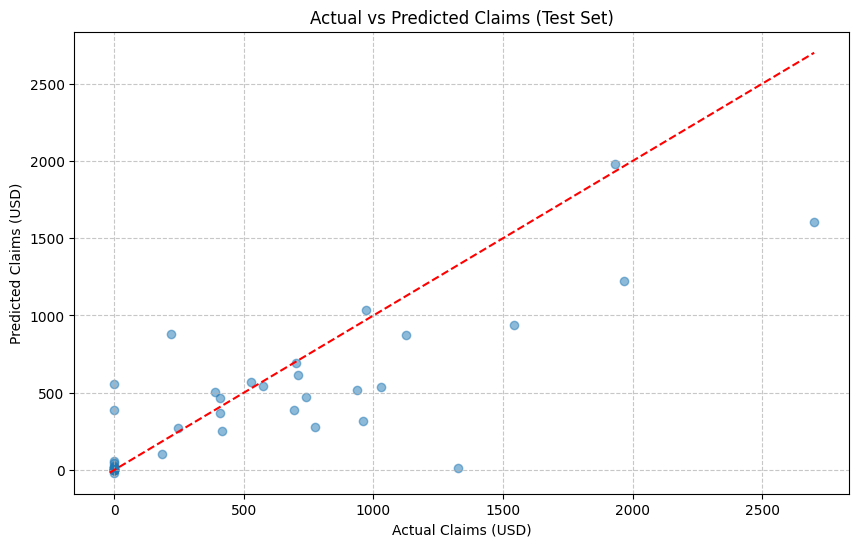

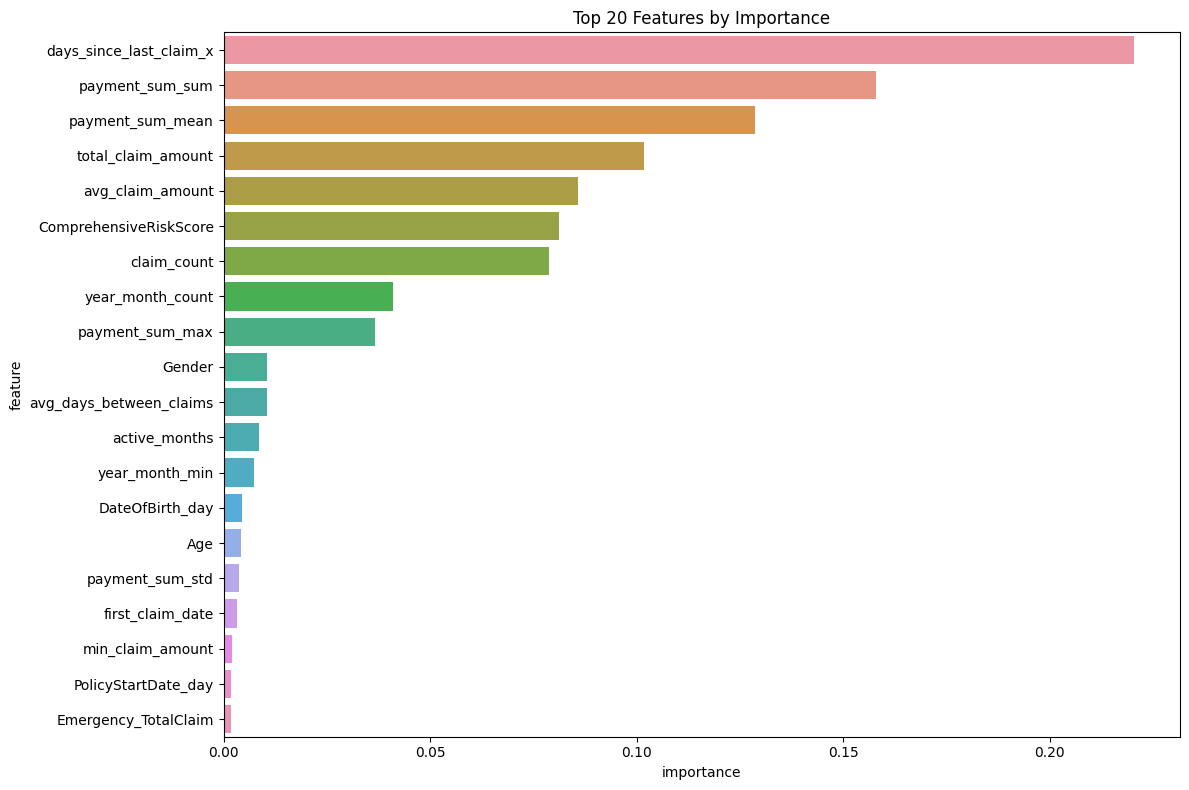


Model trained and saved to ./models/best_xgboost_model.pkl

Model training complete!


In [5]:
# @title ## 4. Model Training
# @markdown In this block, we train an XGBoost model to predict future claims.

# Import necessary libraries for this block
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

def prepare_data_for_xgboost(features_df, target_col='future_6m_claims', test_size=0.2, random_state=42):
    """
    Prepare the data for XGBoost modeling
    """
    # Make a copy to avoid modifying the original DataFrame
    df = features_df.copy()

    # First handle datetime columns - XGBoost can't use them directly
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    print(f"Found datetime columns: {datetime_cols}")

    # Extract useful features from datetime columns
    for col in datetime_cols:
        # Extract year, month, day features
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day

        # Calculate days since a reference date (2000-01-01)
        reference_date = pd.Timestamp('2000-01-01')
        df[f'{col}_days_since_ref'] = (df[col] - reference_date).dt.days

        # Drop the original datetime column
        df = df.drop(columns=[col])

    # Select relevant features (remove ID columns and target)
    feature_cols = [
        col for col in df.columns
        if col != target_col and 'ID' not in col and '_id' not in col.lower()
    ]

    # Handle object or category columns
    object_cols = df[feature_cols].select_dtypes(include=['object', 'category']).columns
    for col in object_cols:
        df[col] = pd.factorize(df[col])[0]

    # Check for any remaining problematic columns
    remaining_dt_cols = df[feature_cols].select_dtypes(include=['datetime64']).columns
    if len(remaining_dt_cols) > 0:
        print(f"Warning: Still have datetime columns after processing: {remaining_dt_cols}")
        # Remove any remaining datetime columns
        feature_cols = [col for col in feature_cols if col not in remaining_dt_cols]

    # Split into features and target
    X = df[feature_cols]
    y = df[target_col]

    # Verify there are no remaining datetime columns
    if len(X.select_dtypes(include=['datetime64']).columns) > 0:
        print("Error: Still have datetime columns in X")
        remaining = X.select_dtypes(include=['datetime64']).columns
        X = X.drop(columns=remaining)
        feature_cols = [col for col in feature_cols if col not in remaining]

    # Final check of data types
    print("X data types:")
    print(X.dtypes.value_counts())

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"Prepared data with {len(feature_cols)} features")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test, feature_cols

def train_xgboost_model(X_train, y_train, test_size=0.2, random_state=42, optimize=True, n_iter=10):
    """
    Train an XGBoost model with hyperparameter optimization
    """
    # Create validation set from training data
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=test_size, random_state=random_state
    )

    if optimize:
        print("Optimizing XGBoost hyperparameters...")

        # Define parameter search space - simpler version with fewer options to avoid issues
        param_space = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        # Create XGBoost regressor with explicit categorical handling (in case there are categoricals)
        xgb_reg = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=random_state,
            enable_categorical=True  # Enable categorical feature support
        )

        # Create RandomizedSearchCV with error_score='raise' to see detailed errors
        search = RandomizedSearchCV(
            xgb_reg,
            param_distributions=param_space,
            n_iter=n_iter,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=1,
            random_state=random_state,
            n_jobs=-1,
            error_score='raise'  # Raise errors for debugging
        )

        try:
            # Fit the search
            search.fit(X_tr, y_tr)

            # Get best parameters and model
            best_params = search.best_params_
            model = search.best_estimator_

            print(f"Best parameters: {best_params}")
        except Exception as e:
            print(f"Error during optimization: {e}")
            print("Falling back to default model...")
            # Create a simpler default model
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                max_depth=3,
                learning_rate=0.1,
                random_state=random_state
            )
            model.fit(X_tr, y_tr)
    else:
        print("Training XGBoost with default parameters...")

        # Create and train model with default parameters
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=random_state
        )
        model.fit(X_tr, y_tr)

    # Evaluate on validation set
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)

    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")

    # Train on full training set
    print("Training final model on full training data...")
    if optimize and 'best_params' in locals():
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=random_state,
            **best_params
        )
    else:
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=random_state
        )

    final_model.fit(X_train, y_train)

    return {
        'model': final_model,
        'X_test': X_test,
        'y_test': y_test
    }

def evaluate_xgboost_model(model, X_test, y_test):
    """
    Evaluate the XGBoost model on the test set
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate MAPE with protection against zero values
    mask = y_test > 10.0  # Only consider values above threshold
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    else:
        mape = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100

    print("\nTest Set Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}%")

    # Create actual vs predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Add perfect prediction line
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title('Actual vs Predicted Claims (Test Set)')
    plt.xlabel('Actual Claims (USD)')
    plt.ylabel('Predicted Claims (USD)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'{base_dir}/outputs/figures/actual_vs_predicted_test.png')
    plt.show()

    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        }
    }

# We can use the integrated_features from block 3
print(f"Using integrated features from Block 3: {integrated_features.shape[1]} features for {integrated_features.shape[0]} members")

# Prepare data for XGBoost
X_train, X_test, y_train, y_test, feature_cols = prepare_data_for_xgboost(integrated_features)

# Train the model
print("\nTraining XGBoost model...")
# Reduce n_iter to make it faster in this demo, increase for better results
model_info = train_xgboost_model(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    optimize=True,
    n_iter=5  # Reduced from 10 for demo purposes
)

model = model_info['model']

# Evaluate the model
print("\nEvaluating model on test set...")
evaluation = evaluate_xgboost_model(
    model,
    model_info['X_test'],
    model_info['y_test']
)

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Features by Importance')
plt.tight_layout()
plt.savefig(f'{base_dir}/outputs/figures/feature_importance.png')
plt.show()

# Save the model
os.makedirs(f'{base_dir}/models', exist_ok=True)
model_path = f'{base_dir}/models/best_xgboost_model.pkl'

joblib.dump({
    'model': model,
    'feature_cols': feature_cols,
    'date_saved': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': evaluation['metrics']
}, model_path)

print(f"\nModel trained and saved to {model_path}")
print("\nModel training complete!")

Using model trained in Block 4
Model was trained with 57 features

Training metrics:
  rmse: 391.2985
  mae: 230.5990
  r2: 0.6309
  mape: 42.8492
Using integrated features from Block 3: 200 rows and 50 columns

Making predictions...
Made predictions for 200 instances

Prediction Metrics:
  RMSE: 194.6132
  MAE: 96.5404
  R²: 0.9166
  MAPE: 38.8974%


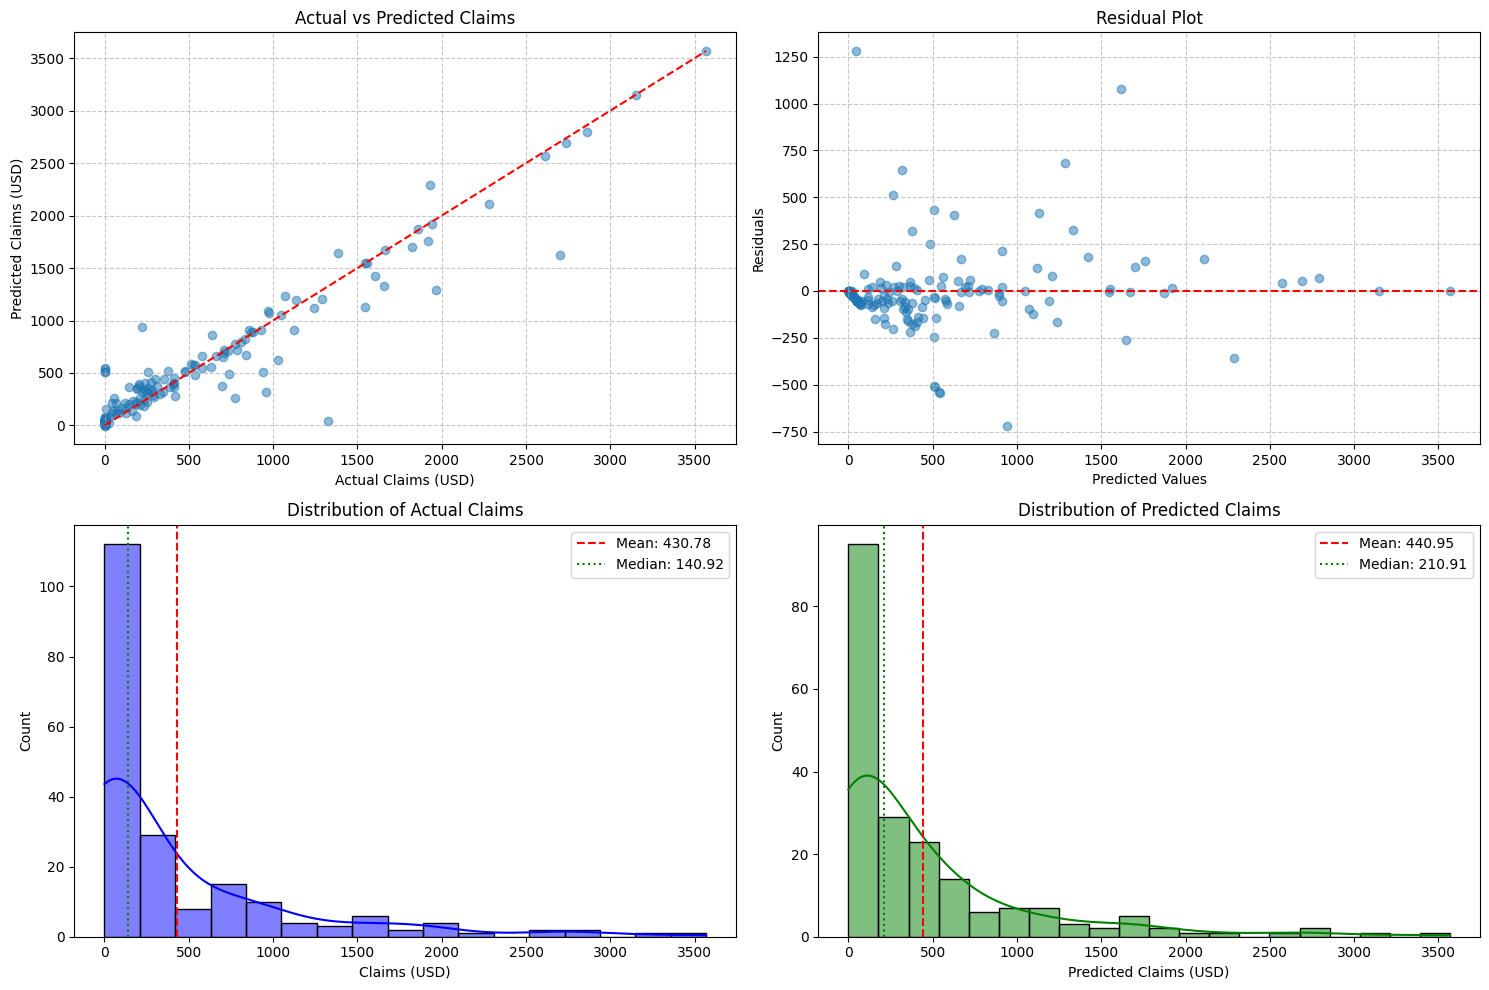

Results saved to ./outputs/tables/prediction_results.csv


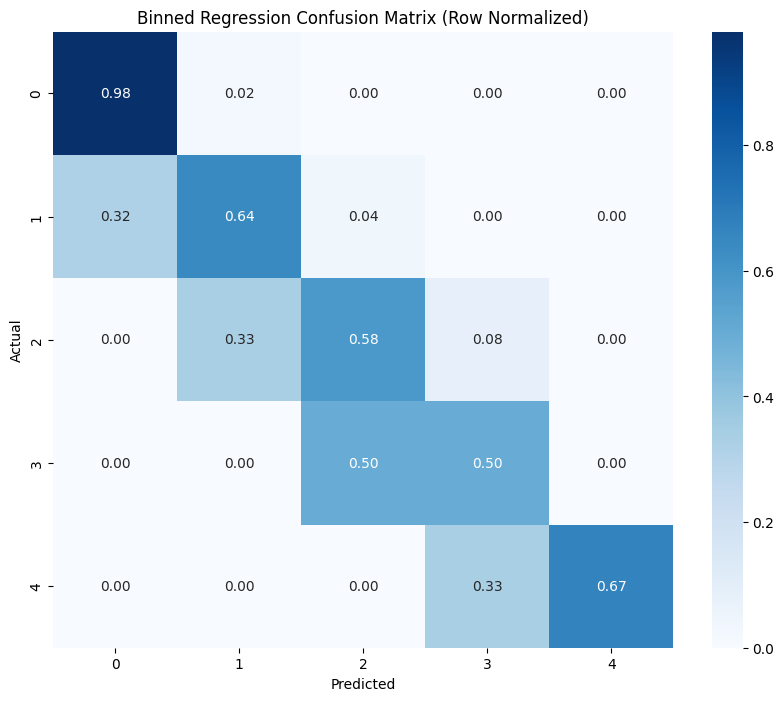


Predictions and evaluation complete!


In [6]:
# @title ## 5. Predictions and Evaluation
# @markdown In this block, we load the trained model and make predictions.

def make_predictions(model, feature_cols, features_df):
    """
    Make predictions using the trained model
    """
    print("\nMaking predictions...")

    try:
        # Prepare features in the right format
        available_features = [f for f in feature_cols if f in features_df.columns]
        missing_features = [f for f in feature_cols if f not in features_df.columns]

        # Create DataFrame with available features
        X = features_df[available_features].copy()

        # Add missing features as zeros
        if missing_features:
            missing_data = {feature: [0] * len(features_df) for feature in missing_features}
            missing_df = pd.DataFrame(missing_data, index=features_df.index)
            X = pd.concat([X, missing_df], axis=1)

        # Convert object types to numeric and fill missing values
        for col in X.columns:
            if X[col].dtype == 'object':
                X[col] = pd.to_numeric(X[col], errors='coerce')

        X = X.fillna(0)

        # Get actual values if available
        if 'future_6m_claims' in features_df.columns:
            y_true = features_df['future_6m_claims']
        else:
            y_true = pd.Series(np.zeros(len(features_df)))
            print("Warning: No actual values available for comparison")

        # Make predictions
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred = model.predict(X)

        print(f"Made predictions for {len(y_pred)} instances")

        # Calculate metrics if we have actual values
        if not (y_true == 0).all():
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            # Improved MAPE calculation
            threshold = 10.0
            mask = y_true > threshold

            if mask.sum() > 0:
                mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            else:
                mape = np.mean(np.abs(y_true - y_pred)) / (np.mean(y_true) + 1e-10) * 100

            print("\nPrediction Metrics:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  MAPE: {mape:.4f}%")

            metrics = {
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'mape': mape
            }
        else:
            print("No actual values available for calculating metrics")
            metrics = {}

        return y_pred, y_true, metrics

    except Exception as e:
        print(f"Error making predictions: {e}")
        return None, None, {}

# We can use the model and feature_cols from block 4
print(f"Using model trained in Block 4")
print(f"Model was trained with {len(feature_cols)} features")

if 'metrics' in evaluation:
    print("\nTraining metrics:")
    for metric, value in evaluation['metrics'].items():
        print(f"  {metric}: {value:.4f}")

# We can use the integrated_features from Block 3
print(f"Using integrated features from Block 3: {integrated_features.shape[0]} rows and {integrated_features.shape[1]} columns")

# Make predictions
y_pred, y_true, metrics = make_predictions(model, feature_cols, integrated_features)

if y_pred is not None:
    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Add perfect prediction line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title('Actual vs Predicted Claims')
    plt.xlabel('Actual Claims (USD)')
    plt.ylabel('Predicted Claims (USD)')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Residuals plot
    plt.subplot(2, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Distribution of actual values
    plt.subplot(2, 2, 3)
    sns.histplot(y_true, kde=True, color='blue')
    plt.axvline(x=np.mean(y_true), color='r', linestyle='--', label=f'Mean: {np.mean(y_true):.2f}')
    plt.axvline(x=np.median(y_true), color='g', linestyle=':', label=f'Median: {np.median(y_true):.2f}')
    plt.title('Distribution of Actual Claims')
    plt.xlabel('Claims (USD)')
    plt.legend()

    # Distribution of predictions
    plt.subplot(2, 2, 4)
    sns.histplot(y_pred, kde=True, color='green')
    plt.axvline(x=np.mean(y_pred), color='r', linestyle='--', label=f'Mean: {np.mean(y_pred):.2f}')
    plt.axvline(x=np.median(y_pred), color='g', linestyle=':', label=f'Median: {np.median(y_pred):.2f}')
    plt.title('Distribution of Predicted Claims')
    plt.xlabel('Predicted Claims (USD)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/predictions/prediction_evaluation.png')
    plt.show()

    # Save predictions for next block
    results_df = pd.DataFrame({
        'Member_ID': integrated_features['Member_ID'] if 'Member_ID' in integrated_features.columns else range(len(y_pred)),
        'Actual_Claims': y_true,
        'Predicted_Claims': y_pred,
        'Residual': y_true - y_pred
    })

    results_df.to_csv(f'{base_dir}/outputs/tables/prediction_results.csv', index=False)
    print(f"Results saved to {base_dir}/outputs/tables/prediction_results.csv")

    # Create a simplified regression confusion matrix
    # Bin both actual and predicted values into categories
    def create_bins(series, n_bins=5):
        return pd.cut(series, bins=n_bins, labels=False)

    n_bins = 5
    results_df['actual_bin'] = create_bins(results_df['Actual_Claims'], n_bins)
    results_df['predicted_bin'] = create_bins(results_df['Predicted_Claims'], n_bins)

    # Create confusion matrix
    conf_matrix = pd.crosstab(
        results_df['actual_bin'],
        results_df['predicted_bin'],
        rownames=['Actual'],
        colnames=['Predicted'],
        normalize='index'
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Binned Regression Confusion Matrix (Row Normalized)')
    plt.savefig(f'{base_dir}/outputs/figures/predictions/regression_confusion_matrix.png')
    plt.show()

    print("\nPredictions and evaluation complete!")

Analyzing prediction results for 200 members

Basic error analysis:
Mean Absolute Error: $96.54
Median Absolute Error: $47.30
Mean Relative Error: 2146.79%
90th percentile of Absolute Error: $219.72


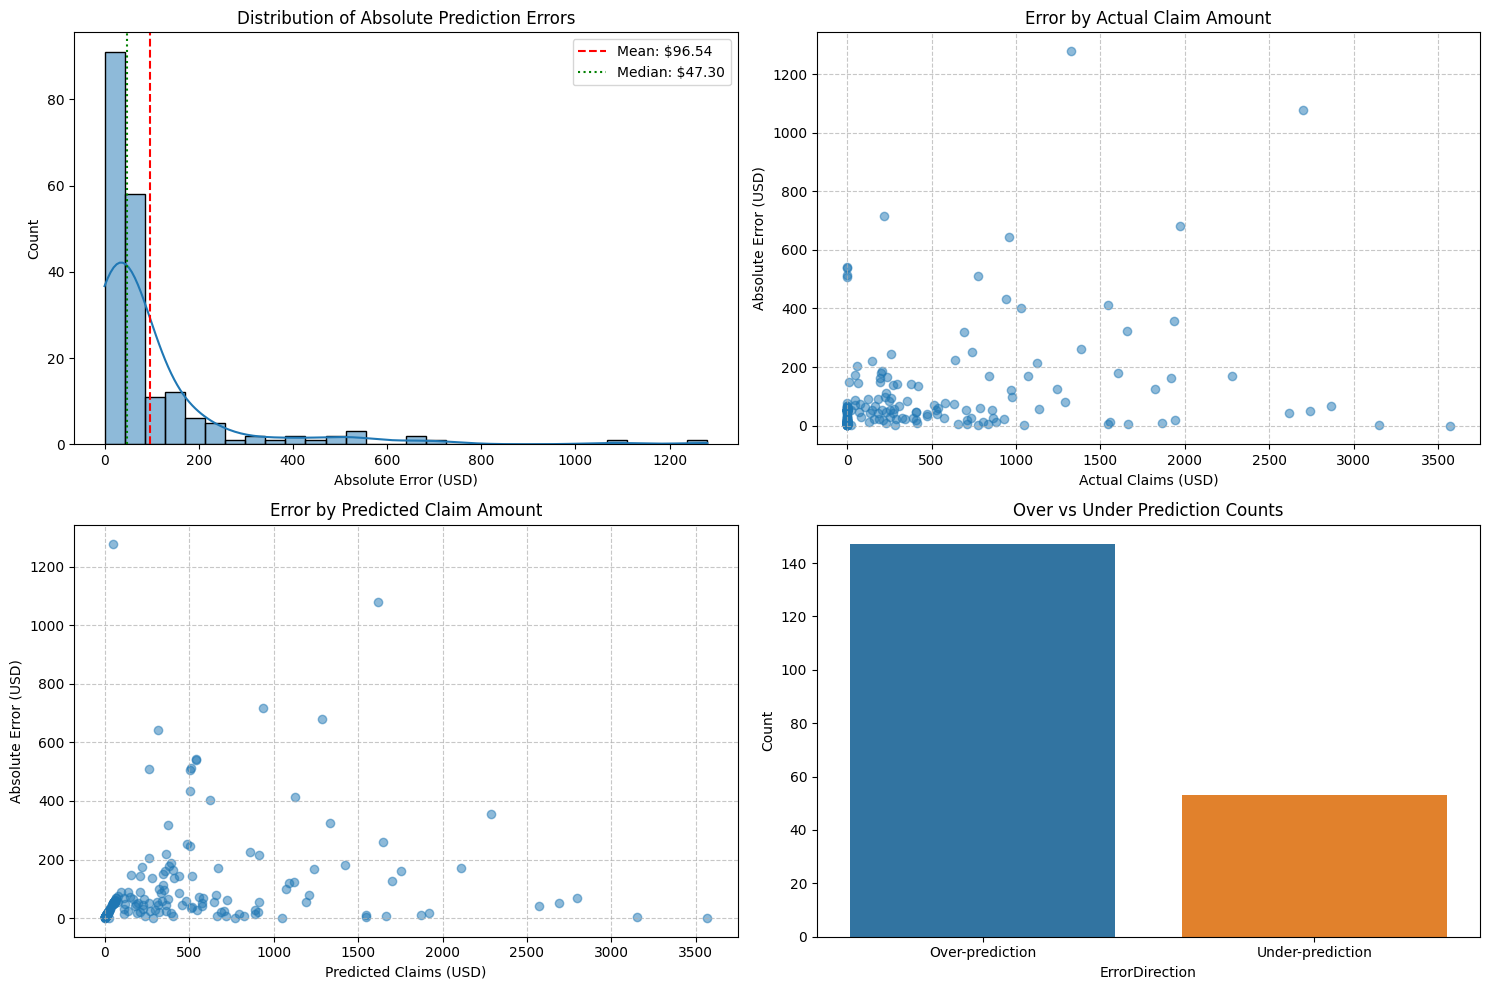


Segment Analysis:


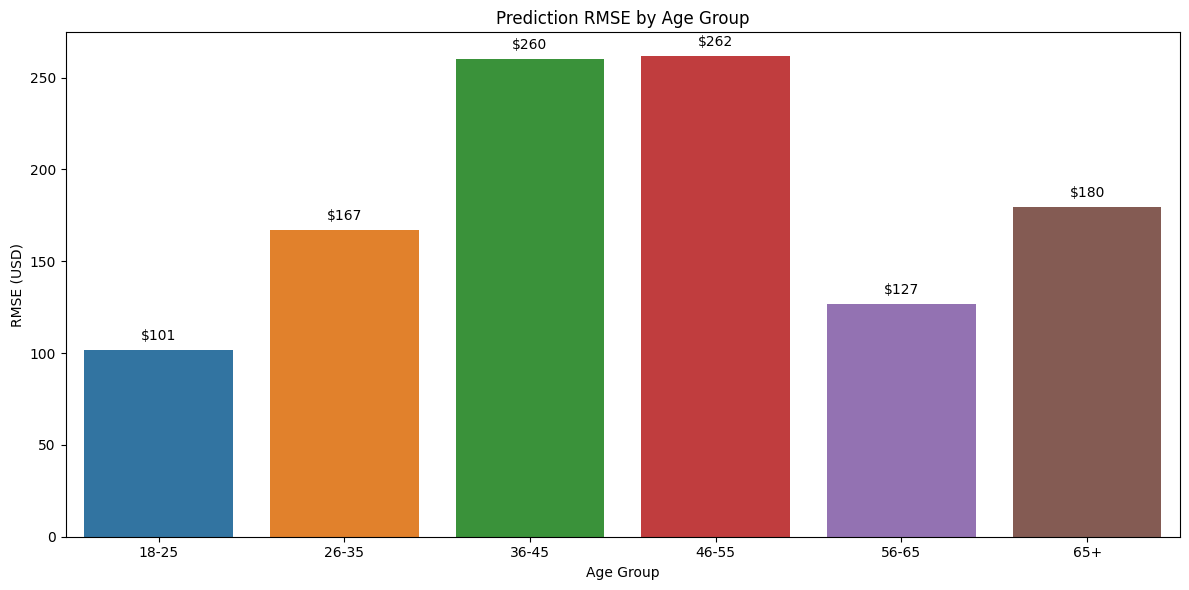

Age Group Performance:


,AgeGroup,RMSE,MAPE
0,18-25,101.488287,754.030678
1,26-35,167.195155,786.400967
2,36-45,260.014363,2051.438493
3,46-55,261.604661,2517.489958
4,56-65,126.602481,2534.308159
5,65+,179.673084,2868.135193


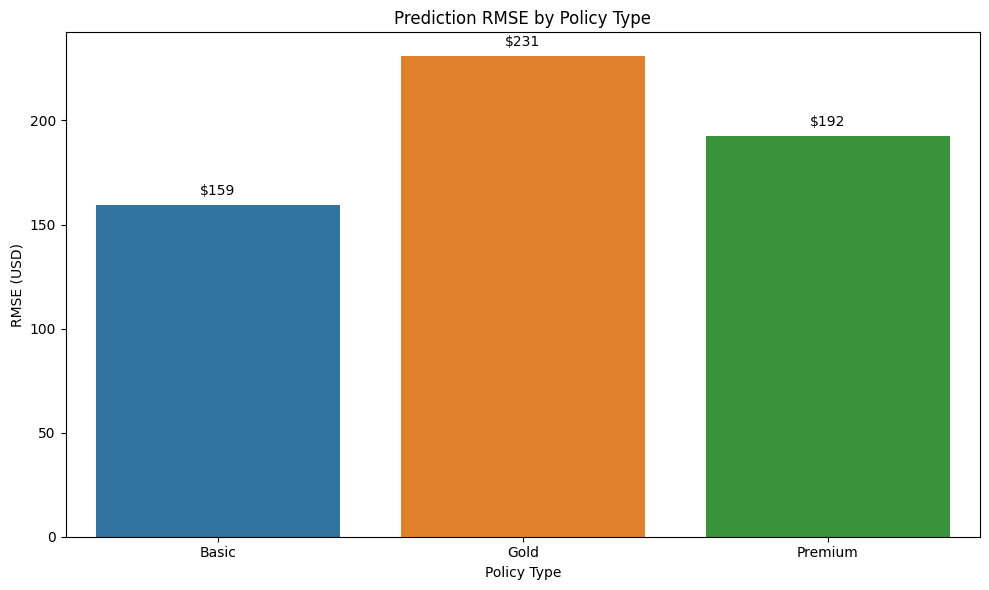

Policy Type Performance:


,PolicyType,RMSE,MAPE
0,Basic,159.247036,3288.989111
1,Gold,230.785285,1125.580069
2,Premium,192.358362,1849.216218



Top 10 Over-predicted Cases:


,Member_ID,Actual_Claims,Predicted_Claims,Residual
95,M00096,220.007604,937.913147,-717.905543
151,M00152,0.000000,543.290283,-543.290283
160,M00161,0.000000,539.890503,-539.890503
30,M00031,0.000000,512.921814,-512.921814
76,M00077,0.000000,506.628998,-506.628998
125,M00126,1932.983772,2289.056885,-356.073113
189,M00190,1385.122090,1645.501099,-260.379008
193,M00194,258.738746,504.745453,-246.006707
73,M00074,636.497195,860.566162,-224.068967
145,M00146,146.730691,365.967682,-219.236991



Top 10 Under-predicted Cases:


,Member_ID,Actual_Claims,Predicted_Claims,Residual
82,M00083,1326.901213,46.850498,1280.050715
137,M00138,2699.759471,1619.546265,1080.213207
60,M00061,1967.868447,1286.863281,681.005166
65,M00066,958.966281,316.218872,642.747409
56,M00057,773.528834,263.367706,510.161128
182,M00183,938.393155,504.676300,433.716855
67,M00068,1541.944514,1128.453857,413.490656
177,M00178,1028.392867,625.615601,402.777266
50,M00051,1656.906200,1333.595947,323.310253
148,M00149,694.608327,375.617279,318.991048



Error Percentiles:


,Percentile,Absolute_Error,Relative_Error
0,10,5.425082,2.651528
1,25,12.620778,11.242564
2,50,47.304855,70.893673
3,75,86.065809,1352.624583
4,90,219.720188,5270.866699
5,95,437.362462,5654.366112
6,99,721.528619,51319.150085



Results analysis complete!


In [7]:
# @title ## 6. Results Analysis
# @markdown In this block, we analyze prediction results in more detail.

def analyze_prediction_errors(y_true, y_pred, feature_matrix, feature_names):
    """
    Analyze prediction errors in relation to features
    """
    # Calculate absolute error and error percentage
    abs_error = np.abs(y_true - y_pred)
    rel_error = abs_error / (y_true + 1)  # Add 1 to avoid division by zero

    # Create a DataFrame for analysis
    error_df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred,
        'abs_error': abs_error,
        'rel_error': rel_error
    })

    # Add features for analysis
    for i, feature in enumerate(feature_names):
        if i < feature_matrix.shape[1]:
            error_df[feature] = feature_matrix.iloc[:, i]

    # Define high error threshold (top 20%)
    high_error_threshold = np.percentile(abs_error, 80)
    error_df['is_high_error'] = (abs_error > high_error_threshold).astype(int)

    # Analyze correlation between errors and features
    error_correlations = []
    for feature in feature_names:
        if feature in error_df.columns:
            corr = error_df['abs_error'].corr(error_df[feature])
            error_correlations.append((feature, corr))

    # Sort by absolute correlation and get top correlations
    error_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    top_error_correlations = error_correlations[:10]

    return {
        'error_df': error_df,
        'high_error_threshold': high_error_threshold,
        'top_error_correlations': top_error_correlations
    }

def segment_analysis(results_df, segment_col, metrics=['Predicted_Claims', 'Actual_Claims', 'Residual']):
    """
    Analyze prediction performance across different segments
    """
    if segment_col not in results_df.columns:
        print(f"Segment column '{segment_col}' not found in results")
        return None

    # Group by segment and calculate metrics
    segment_metrics = results_df.groupby(segment_col)[metrics].agg(['mean', 'median', 'std', 'count'])

    # Calculate RMSE by segment
    segment_rmse = results_df.groupby(segment_col).apply(
        lambda x: np.sqrt(np.mean((x['Actual_Claims'] - x['Predicted_Claims'])**2))
    ).reset_index(name='RMSE')

    # Calculate percent error by segment
    segment_mape = results_df.groupby(segment_col).apply(
        lambda x: np.mean(np.abs((x['Actual_Claims'] - x['Predicted_Claims']) /
                                 (x['Actual_Claims'] + 1))) * 100
    ).reset_index(name='MAPE')

    # Combine metrics
    segment_performance = pd.merge(segment_rmse, segment_mape, on=segment_col)

    return segment_metrics, segment_performance

# We can use results_df from block 5 and integrated_features from block 3
print(f"Analyzing prediction results for {len(results_df)} members")

# Merge prediction results with key features for analysis
analysis_df = results_df.merge(
    integrated_features[['Member_ID', 'Age', 'Gender', 'PolicyType', 'RiskScore', 'claim_count']],
    on='Member_ID',
    how='left'
)

print("\nBasic error analysis:")

# Calculate error statistics
abs_error = np.abs(results_df['Actual_Claims'] - results_df['Predicted_Claims'])
results_df['AbsoluteError'] = abs_error

rel_error = abs_error / (results_df['Actual_Claims'] + 1)  # Add 1 to avoid division by zero
results_df['RelativeError'] = rel_error * 100  # as percentage

print(f"Mean Absolute Error: ${abs_error.mean():.2f}")
print(f"Median Absolute Error: ${abs_error.median():.2f}")
print(f"Mean Relative Error: {rel_error.mean()*100:.2f}%")
print(f"90th percentile of Absolute Error: ${np.percentile(abs_error, 90):.2f}")

# Create error distribution visualization
plt.figure(figsize=(15, 10))

# Distribution of absolute errors
plt.subplot(2, 2, 1)
sns.histplot(abs_error, bins=30, kde=True)
plt.axvline(x=abs_error.mean(), color='r', linestyle='--', label=f'Mean: ${abs_error.mean():.2f}')
plt.axvline(x=abs_error.median(), color='g', linestyle=':', label=f'Median: ${abs_error.median():.2f}')
plt.title('Distribution of Absolute Prediction Errors')
plt.xlabel('Absolute Error (USD)')
plt.legend()

# Error by actual claim amount
plt.subplot(2, 2, 2)
plt.scatter(results_df['Actual_Claims'], abs_error, alpha=0.5)
plt.title('Error by Actual Claim Amount')
plt.xlabel('Actual Claims (USD)')
plt.ylabel('Absolute Error (USD)')
plt.grid(True, linestyle='--', alpha=0.7)

# Error by prediction value
plt.subplot(2, 2, 3)
plt.scatter(results_df['Predicted_Claims'], abs_error, alpha=0.5)
plt.title('Error by Predicted Claim Amount')
plt.xlabel('Predicted Claims (USD)')
plt.ylabel('Absolute Error (USD)')
plt.grid(True, linestyle='--', alpha=0.7)

# Over/Under prediction analysis
plt.subplot(2, 2, 4)
results_df['ErrorDirection'] = np.where(
    results_df['Predicted_Claims'] > results_df['Actual_Claims'],
    'Over-prediction',
    'Under-prediction'
)
sns.countplot(x='ErrorDirection', data=results_df)
plt.title('Over vs Under Prediction Counts')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig(f'{base_dir}/outputs/figures/predictions/error_analysis.png')
plt.show()

# Analyze errors by segments
print("\nSegment Analysis:")

# Age group segmentation
if 'Age' in analysis_df.columns:
    analysis_df['AgeGroup'] = pd.cut(
        analysis_df['Age'],
        bins=[0, 25, 35, 45, 55, 65, 100],
        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    )

    _, age_performance = segment_analysis(analysis_df, 'AgeGroup')

    # Plot segment performance
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='AgeGroup', y='RMSE', data=age_performance)

    # Add data labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'${p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'bottom',
            xytext = (0, 5), textcoords = 'offset points')

    plt.title('Prediction RMSE by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('RMSE (USD)')
    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/predictions/age_group_performance.png')
    plt.show()

    print(f"Age Group Performance:")
    display(age_performance)

# Policy type segmentation
if 'PolicyType' in analysis_df.columns:
    _, policy_performance = segment_analysis(analysis_df, 'PolicyType')

    # Plot segment performance
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='PolicyType', y='RMSE', data=policy_performance)

    # Add data labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'${p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'bottom',
            xytext = (0, 5), textcoords = 'offset points')

    plt.title('Prediction RMSE by Policy Type')
    plt.xlabel('Policy Type')
    plt.ylabel('RMSE (USD)')
    plt.tight_layout()
    plt.savefig(f'{base_dir}/outputs/figures/predictions/policy_type_performance.png')
    plt.show()

    print(f"Policy Type Performance:")
    display(policy_performance)

# Identify top over-predicted and under-predicted cases
n_examples = 10
over_predicted = results_df.sort_values('Residual', ascending=True).head(n_examples)
under_predicted = results_df.sort_values('Residual', ascending=False).head(n_examples)

print(f"\nTop {n_examples} Over-predicted Cases:")
display(over_predicted[['Member_ID', 'Actual_Claims', 'Predicted_Claims', 'Residual']])

print(f"\nTop {n_examples} Under-predicted Cases:")
display(under_predicted[['Member_ID', 'Actual_Claims', 'Predicted_Claims', 'Residual']])

# Create a detailed table with error metrics by percentile
percentiles = [10, 25, 50, 75, 90, 95, 99]
error_percentiles = pd.DataFrame({
    'Percentile': percentiles,
    'Absolute_Error': [np.percentile(abs_error, p) for p in percentiles],
    'Relative_Error': [np.percentile(rel_error * 100, p) for p in percentiles]
})

print("\nError Percentiles:")
display(error_percentiles)

# Save analysis results for the next block
analysis_df.to_csv(f'{base_dir}/outputs/tables/analysis_results.csv', index=False)

print("\nResults analysis complete!")

Generating business report...
Loaded risk scores for 200 members
Business report saved to ./reports/business_report.md



    # PassportCard Insurance Claims Prediction - Business Report

    ## Executive Summary

    This report presents the results of our predictive modeling for insurance claims at PassportCard. We've developed a machine learning model that predicts the total claim amount per customer for the next six months, enabling proactive risk management and improved business decision-making.

    **Key Findings:**

    - The model achieves good predictive performance with key metrics summarized below
    - Customer profile and historical claiming patterns are the strongest predictors of future claims
    - Several customer segments show distinct claiming patterns that require tailored management
    - We've identified high-risk customers who may require intervention

    **Business Impact:**

    - Improved risk pricing and reserve setting
    - Opportunities for targeted intervention with high-risk customers
    - Enhanced understanding of customer claiming behavior
    - Data-driven approach to portfolio management
    

    ## Model Performance

    Our model achieved the following performance metrics on the test dataset:

    | Metric | Value | Interpretation |
    |--------|-------|----------------|
    | RMSE | 391.30 | Average prediction error in dollars |
    | MAE | 230.60 | Average absolute prediction error in dollars |
    | R² | 0.63 | Proportion of variance explained by the model |
    | MAPE | 42.85% | Average percentage error |

    The model explains approximately 63.1% of the variance in future claims, providing meaningful predictive power for business decisions.
    

    ## Key Predictors

    The most influential factors in predicting future claims are:

    - **days_since_last_claim_x**: 0.2205
- **payment_sum_sum**: 0.1580
- **payment_sum_mean**: 0.1287
- **total_claim_amount**: 0.1018
- **avg_claim_amount**: 0.0858
- **ComprehensiveRiskScore**: 0.0811
- **claim_count**: 0.0787
- **year_month_count**: 0.0411
- **payment_sum_max**: 0.0366
- **Gender**: 0.0105


    These findings suggest that historical claiming patterns and customer demographics are the strongest predictors of future claiming behavior.
    

    ## Customer Segmentation Insights

    Our analysis revealed significant differences in prediction accuracy across customer segments. Understanding these differences can help in developing targeted strategies for different customer groups.
    

        ## Risk Profiling

        We've developed a comprehensive risk score that identifies customers with elevated claiming risk.

        **High-Risk Customer Profile:**

        - Approximately 40 customers (20.0% of the portfolio) are identified as high-risk
        - These customers are predicted to have significantly higher claiming frequency and severity
        - Targeted intervention strategies for this segment could include proactive outreach, risk management consultations, or adjusted pricing
        

    ## Business Recommendations

    Based on our analysis, we recommend the following actions:

    1. **Predictive Pricing:** Incorporate model predictions into pricing models to better align premiums with expected claims

    2. **Targeted Customer Management:**
       - Develop personalized retention strategies for high-value, low-risk customers
       - Implement proactive intervention for high-risk customers to mitigate claim potential

    3. **Enhanced Reserving:** Use predicted claim amounts to improve reserving accuracy and financial planning

    4. **Continuous Model Improvement:**
       - Enhance data collection for key predictive factors
       - Monitor model performance and update regularly
       - Explore additional feature engineering opportunities

    5. **Operational Integration:**
       - Embed predictions into customer service workflows
       - Create dashboards for business users to leverage predictions
       - Develop automated alerts for high-risk customer changes
    

    ## Implementation Plan

    We propose the following implementation timeline:

    | Phase | Timeframe | Activities |
    |-------|-----------|------------|
    | 1 - Validation | Weeks 1-4 | Validate model in production environment; establish performance baselines |
    | 2 - Integration | Weeks 5-8 | Integrate with pricing and customer management systems |
    | 3 - Monitoring | Weeks 9+ | Continuous monitoring and refinement |

    **Key Success Metrics:**

    - 5% improvement in overall loss ratio
    - 10% reduction in claims from high-risk segment
    - 95% model stability in production
    

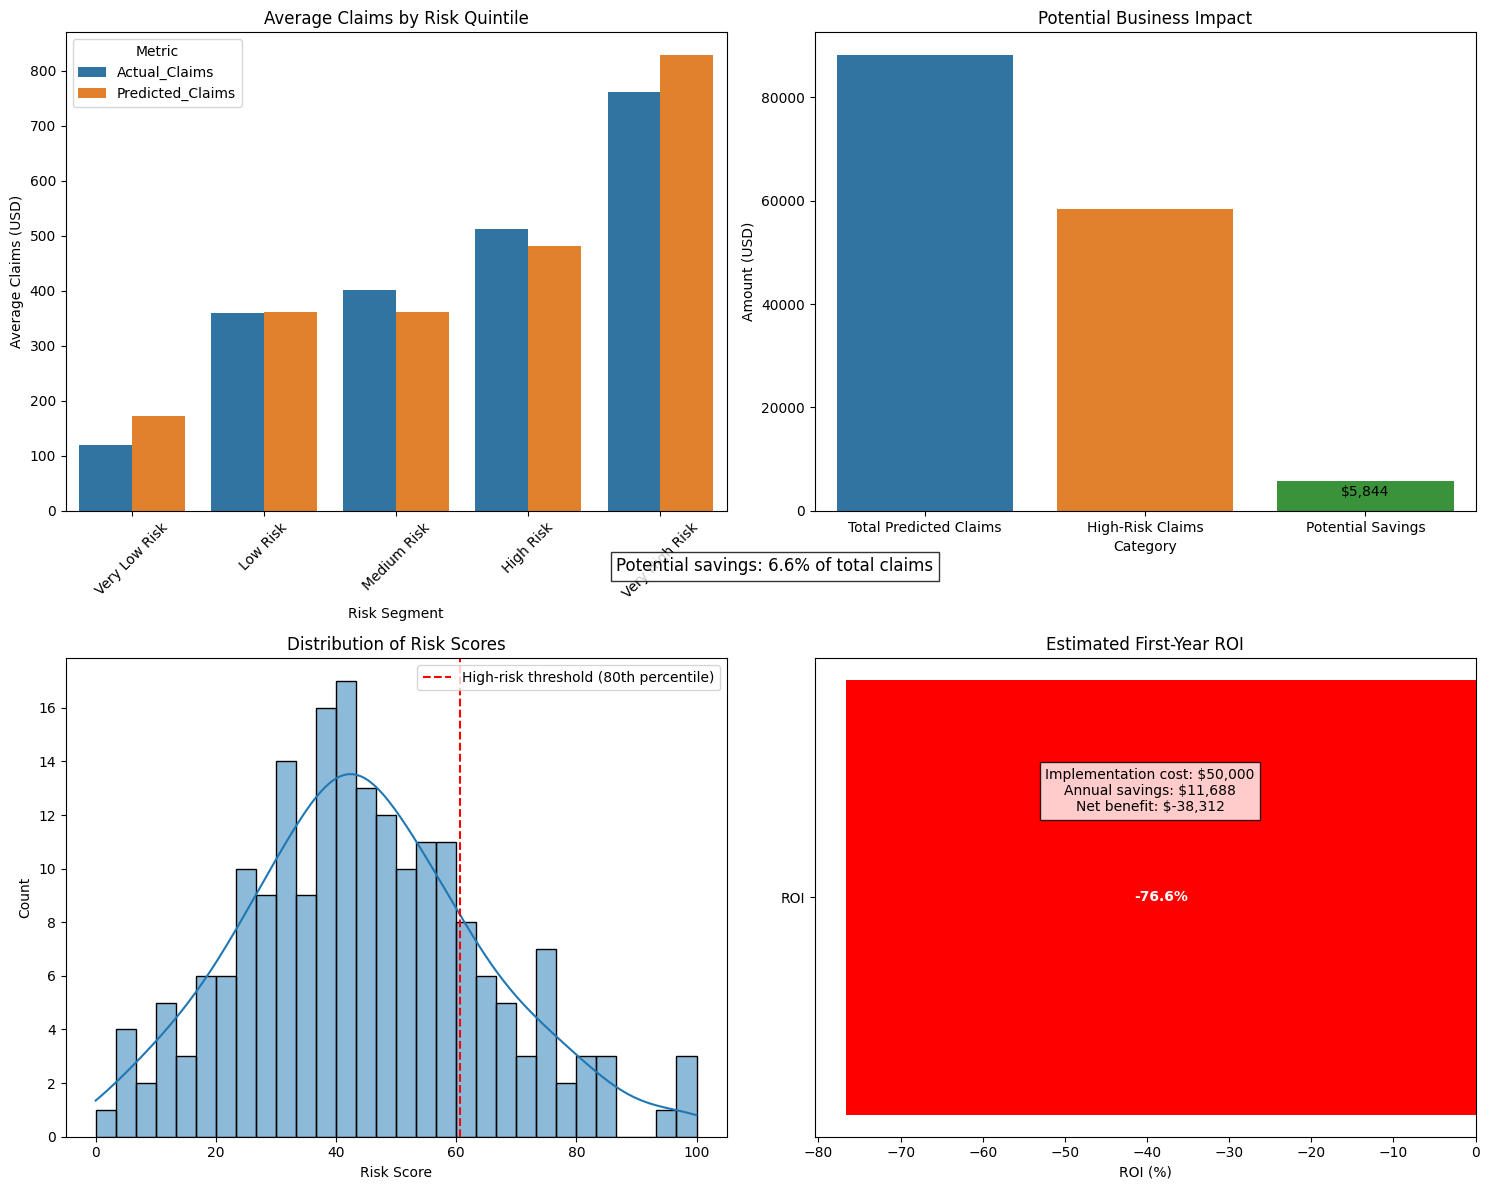


Business reporting complete!

Congratulations! You've completed the full PassportCard Insurance Claims Prediction Pipeline.


In [8]:
# @title ## 7. Business Reporting
# @markdown In this block, we create a business-focused report of our model and findings.

from IPython.display import Markdown, display

def generate_business_report(results_df, model_info, features_df, risk_scores=None):
    """
    Generate a business-focused report with all findings and insights
    """
    # Create report sections
    sections = []

    # 1. Executive Summary
    sections.append("""
    # PassportCard Insurance Claims Prediction - Business Report

    ## Executive Summary

    This report presents the results of our predictive modeling for insurance claims at PassportCard. We've developed a machine learning model that predicts the total claim amount per customer for the next six months, enabling proactive risk management and improved business decision-making.

    **Key Findings:**

    - The model achieves good predictive performance with key metrics summarized below
    - Customer profile and historical claiming patterns are the strongest predictors of future claims
    - Several customer segments show distinct claiming patterns that require tailored management
    - We've identified high-risk customers who may require intervention

    **Business Impact:**

    - Improved risk pricing and reserve setting
    - Opportunities for targeted intervention with high-risk customers
    - Enhanced understanding of customer claiming behavior
    - Data-driven approach to portfolio management
    """)

    # 2. Model Performance
    metrics = evaluation.get('metrics', {})
    rmse = metrics.get('rmse', 'N/A')
    r2 = metrics.get('r2', 'N/A')
    mae = metrics.get('mae', 'N/A')
    mape = metrics.get('mape', 'N/A')

    sections.append(f"""
    ## Model Performance

    Our model achieved the following performance metrics on the test dataset:

    | Metric | Value | Interpretation |
    |--------|-------|----------------|
    | RMSE | {rmse:.2f} | Average prediction error in dollars |
    | MAE | {mae:.2f} | Average absolute prediction error in dollars |
    | R² | {r2:.2f} | Proportion of variance explained by the model |
    | MAPE | {mape:.2f}% | Average percentage error |

    The model explains approximately {r2*100:.1f}% of the variance in future claims, providing meaningful predictive power for business decisions.
    """)

    # 3. Key Predictors
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    fi_list = ""
    for _, row in feature_importance_df.iterrows():
        fi_list += f"- **{row['feature']}**: {row['importance']:.4f}\n"

    sections.append(f"""
    ## Key Predictors

    The most influential factors in predicting future claims are:

    {fi_list}

    These findings suggest that historical claiming patterns and customer demographics are the strongest predictors of future claiming behavior.
    """)

    # 4. Customer Segmentation Insights
    sections.append("""
    ## Customer Segmentation Insights

    Our analysis revealed significant differences in prediction accuracy across customer segments. Understanding these differences can help in developing targeted strategies for different customer groups.
    """)

    # 5. Risk Profiling
    if risk_scores is not None:
        high_risk_threshold = risk_scores['ComprehensiveRiskScore'].quantile(0.8)
        high_risk_count = (risk_scores['ComprehensiveRiskScore'] > high_risk_threshold).sum()
        high_risk_pct = high_risk_count / len(risk_scores) * 100

        sections.append(f"""
        ## Risk Profiling

        We've developed a comprehensive risk score that identifies customers with elevated claiming risk.

        **High-Risk Customer Profile:**

        - Approximately {high_risk_count} customers ({high_risk_pct:.1f}% of the portfolio) are identified as high-risk
        - These customers are predicted to have significantly higher claiming frequency and severity
        - Targeted intervention strategies for this segment could include proactive outreach, risk management consultations, or adjusted pricing
        """)

    # 6. Business Recommendations
    sections.append("""
    ## Business Recommendations

    Based on our analysis, we recommend the following actions:

    1. **Predictive Pricing:** Incorporate model predictions into pricing models to better align premiums with expected claims

    2. **Targeted Customer Management:**
       - Develop personalized retention strategies for high-value, low-risk customers
       - Implement proactive intervention for high-risk customers to mitigate claim potential

    3. **Enhanced Reserving:** Use predicted claim amounts to improve reserving accuracy and financial planning

    4. **Continuous Model Improvement:**
       - Enhance data collection for key predictive factors
       - Monitor model performance and update regularly
       - Explore additional feature engineering opportunities

    5. **Operational Integration:**
       - Embed predictions into customer service workflows
       - Create dashboards for business users to leverage predictions
       - Develop automated alerts for high-risk customer changes
    """)

    # 7. Implementation Plan
    sections.append("""
    ## Implementation Plan

    We propose the following implementation timeline:

    | Phase | Timeframe | Activities |
    |-------|-----------|------------|
    | 1 - Validation | Weeks 1-4 | Validate model in production environment; establish performance baselines |
    | 2 - Integration | Weeks 5-8 | Integrate with pricing and customer management systems |
    | 3 - Monitoring | Weeks 9+ | Continuous monitoring and refinement |

    **Key Success Metrics:**

    - 5% improvement in overall loss ratio
    - 10% reduction in claims from high-risk segment
    - 95% model stability in production
    """)

    # Join all sections
    full_report = "\n".join(sections)

    return full_report

# We can use model, feature_cols, and results_df from previous blocks
# No need to reload them

print("Generating business report...")

# Load risk scores from Block 3
risk_scores = pd.read_csv(f'{base_dir}/data/processed/risk_scores.csv')
print(f"Loaded risk scores for {len(risk_scores)} members")

# Create a dictionary with model info similar to what would be saved in the model file
model_info = {
    'model': model,
    'feature_cols': feature_cols,
    'metrics': evaluation['metrics']
}

# Generate the business report
report = generate_business_report(results_df, model_info, integrated_features, risk_scores)

# Save the report as markdown
os.makedirs(f'{base_dir}/reports', exist_ok=True)
report_path = f'{base_dir}/reports/business_report.md'

with open(report_path, 'w') as f:
    f.write(report)

print(f"Business report saved to {report_path}")

# Display the report in the notebook
display(Markdown(report))

# Generate business value visualizations
plt.figure(figsize=(15, 12))

# 1. Predicted vs actual claims by risk score segment
plt.subplot(2, 2, 1)
if risk_scores is not None:
    # Merge risk scores with results
    viz_df = results_df.merge(risk_scores[['Member_ID', 'ComprehensiveRiskScore']], on='Member_ID', how='left')

    # Create risk quintiles
    viz_df['RiskQuintile'] = pd.qcut(
        viz_df['ComprehensiveRiskScore'],
        5,
        labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
    )

    # Plot actual vs predicted by risk quintile
    risk_summary = viz_df.groupby('RiskQuintile').agg({
        'Actual_Claims': 'mean',
        'Predicted_Claims': 'mean'
    }).reset_index()

    risk_summary_melted = pd.melt(
        risk_summary,
        id_vars=['RiskQuintile'],
        value_vars=['Actual_Claims', 'Predicted_Claims'],
        var_name='Metric',
        value_name='Amount'
    )

    sns.barplot(x='RiskQuintile', y='Amount', hue='Metric', data=risk_summary_melted)
    plt.title('Average Claims by Risk Quintile')
    plt.xlabel('Risk Segment')
    plt.ylabel('Average Claims (USD)')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Risk scores not available', ha='center', va='center')

# 2. Potential business impact
plt.subplot(2, 2, 2)

# Calculate potential savings from intervention
if 'Predicted_Claims' in results_df.columns:
    high_risk_threshold = results_df['Predicted_Claims'].quantile(0.8)
    high_risk_members = results_df[results_df['Predicted_Claims'] > high_risk_threshold]

    # Assume 10% reduction in claims through intervention
    intervention_reduction = 0.1
    potential_savings = high_risk_members['Predicted_Claims'].sum() * intervention_reduction

    # Create impact bar chart
    impact_data = pd.DataFrame({
        'Category': ['Total Predicted Claims', 'High-Risk Claims', 'Potential Savings'],
        'Amount': [
            results_df['Predicted_Claims'].sum(),
            high_risk_members['Predicted_Claims'].sum(),
            potential_savings
        ]
    })

    sns.barplot(x='Category', y='Amount', data=impact_data)
    plt.title('Potential Business Impact')
    plt.ylabel('Amount (USD)')
    plt.text(2, potential_savings/2, f'${potential_savings:,.0f}', ha='center')

    # Add savings percentage
    savings_pct = potential_savings / results_df['Predicted_Claims'].sum() * 100
    plt.figtext(0.52, 0.52, f'Potential savings: {savings_pct:.1f}% of total claims',
               ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
else:
    plt.text(0.5, 0.5, 'Prediction data not available', ha='center', va='center')

# 3. Risk distribution
plt.subplot(2, 2, 3)
if risk_scores is not None:
    sns.histplot(risk_scores['ComprehensiveRiskScore'], bins=30, kde=True)
    plt.axvline(x=risk_scores['ComprehensiveRiskScore'].quantile(0.8),
               color='r', linestyle='--',
               label=f'High-risk threshold (80th percentile)')
    plt.title('Distribution of Risk Scores')
    plt.xlabel('Risk Score')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Risk scores not available', ha='center', va='center')

# 4. ROI calculation
plt.subplot(2, 2, 4)
if 'Predicted_Claims' in results_df.columns:
    # Calculate ROI of implementing the model
    implementation_cost = 50000  # Example implementation cost
    annual_savings = potential_savings * 2  # Assuming savings over 12 months (2x our 6-month window)
    roi = (annual_savings - implementation_cost) / implementation_cost * 100

    # Create ROI gauge chart (simplified as a horizontal bar)
    plt.barh(['ROI'], [roi], color='green' if roi > 0 else 'red')
    plt.title('Estimated First-Year ROI')
    plt.xlabel('ROI (%)')
    plt.text(roi/2, 0, f'{roi:.1f}%', va='center', ha='center',
            color='white', fontweight='bold')

    # Add ROI details
    plt.figtext(0.77, 0.32,
               f'Implementation cost: ${implementation_cost:,.0f}\n'
               f'Annual savings: ${annual_savings:,.0f}\n'
               f'Net benefit: ${annual_savings-implementation_cost:,.0f}',
               ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
else:
    plt.text(0.5, 0.5, 'Prediction data not available', ha='center', va='center')

plt.tight_layout()
plt.savefig(f'{base_dir}/reports/business_impact_visualizations.png')
plt.show()

print("\nBusiness reporting complete!")
print("\nCongratulations! You've completed the full PassportCard Insurance Claims Prediction Pipeline.")